## Prerequisites

Install the dependencies (you can skip this step if they are already installed).

In [ ]:
%pip install fastparquet==2024.5.0
%pip install matplotlib==3.9.1.post1
%pip install numpy==1.26.4
%pip install pandas==2.2.2
%pip install seaborn==0.13.2
%pip install scipy==1.14.1

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3 as sq

from collections import defaultdict, Counter
from functools import lru_cache
import matplotlib.dates as mdates

In [3]:
THE_MERGE_BLOCK_NUMBER = 15537394
THE_MERGE_SLOT = 4700013
THE_MERGE_BLOCK_TIMESTAMP = pd.to_datetime("2022-09-15 06:42:59")
SLOT_TIME = 12


@lru_cache(maxsize=1000)
def calc_slot_timestamp(slot):
    slot_gap = slot - THE_MERGE_SLOT
    time_gap = pd.Timedelta(slot_gap * SLOT_TIME, unit="s")
    return THE_MERGE_BLOCK_TIMESTAMP + time_gap


@lru_cache(maxsize=1000)
def get_timestamp_slot(timestamp):
    time_gap = timestamp - THE_MERGE_BLOCK_TIMESTAMP
    slot_gap = time_gap.total_seconds() / SLOT_TIME
    slot = THE_MERGE_SLOT + int(slot_gap)
    return slot

In [5]:
# data paths
DATA_PATH = "./data"
BLOCK_PATH = os.path.join(DATA_PATH, "eth_blocks.parquet")
BUILDERS_PATH = os.path.join(DATA_PATH, "builders.json")
PRIVATE_TRANSACTIONS_PATH = os.path.join(DATA_PATH, "private_transactions.parquet")
PIVOTAL_BUILDERS_PATH = os.path.join(DATA_PATH, "level.db")

In [4]:
# load the builders data
with open(BUILDERS_PATH, "r") as f:
    builders = json.load(f)

builders = {i:k for k, v in builders.items() for i in v}

In [5]:
# load the blocks data
blocks_df = pd.read_parquet(BLOCK_PATH)
blocks_df["timestamp"] = blocks_df["slot"].apply(calc_slot_timestamp)
blocks_df["date"] = blocks_df["timestamp"].apply(lambda x: x.strftime("%Y%m%d"))

## Computing Market Share

Plotting Figure 1: Market share of builders.

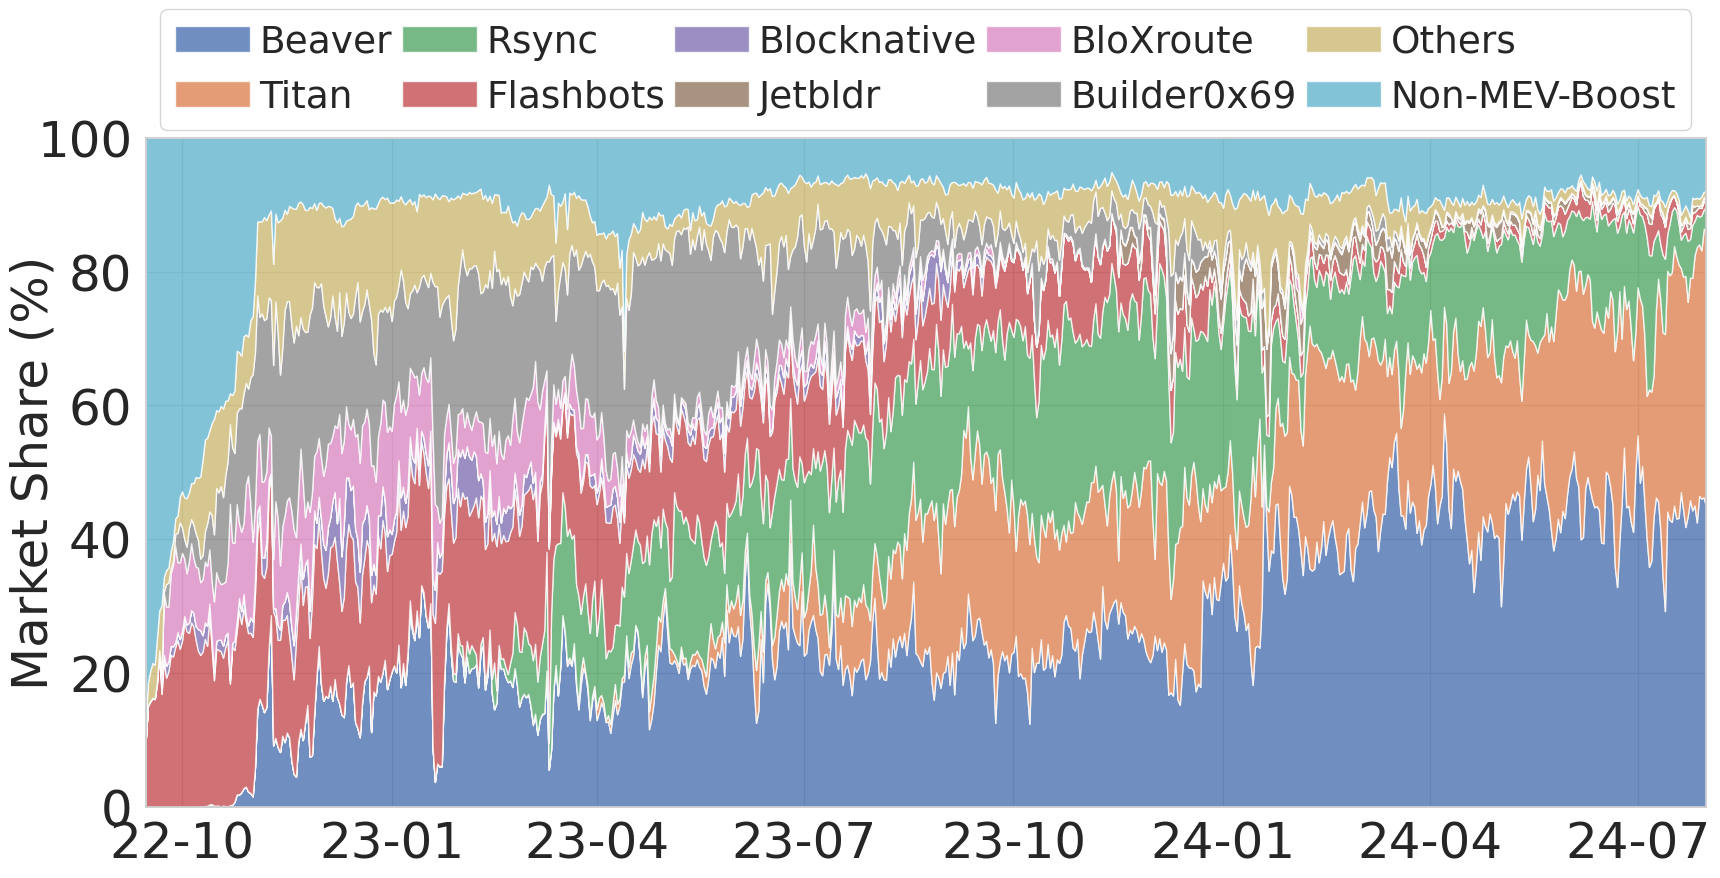

In [ ]:
# Compute the market share of each builder
data = []
builder_count = defaultdict(int)
for date_str, date_df in blocks_df.groupby("date"):
    sub_df = date_df[date_df["builder_pubkey"].notnull()].reindex()
    builder_count["Non-MEV-Boost"] += date_df.shape[0] - sub_df.shape[0]

    data.append((date_str, "Non-MEV-Boost", 100 - 100 * sub_df.shape[0] / date_df.shape[0]))

    sub_df["builder"] = sub_df["builder_pubkey"].apply(lambda x: builders.get(x, x[:12]))
    for builder, builder_df in sub_df.groupby("builder"):
        data.append((date_str, builder, 100 * builder_df.shape[0] / date_df.shape[0]))

# Create the final dataframe
data_df = pd.DataFrame(data, columns=["Date", "Builder", "Percentage"])

# List of builders to keep
builder_list = ['Non-MEV-Boost', 'Flashbots', 'bloXroute', 'builder0x69', 'beaverbuild',
        'rsync-builder', 'Titan', 'jetbldr.xyz', 'Blocknative']

# Mask for others
others_mask = ~data_df['Builder'].isin(builder_list)
others_df = data_df[others_mask].groupby('Date')['Percentage'].sum().reset_index()
others_df['Builder'] = 'Others'
df_kept_metrics = data_df[data_df['Builder'].isin(builder_list)]

# Final df
final_df = pd.concat([df_kept_metrics, others_df])
final_df = final_df.sort_values(by=['Date', 'Builder']).reset_index(drop=True)
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Pivot the dataframe
pivoted_df = final_df.pivot(index='Date', columns='Builder', values='Percentage').fillna(0)
pivoted_df = pivoted_df[["beaverbuild", "Titan", "rsync-builder", "Flashbots", "Blocknative",  "jetbldr.xyz", "bloXroute", "builder0x69", "Others", "Non-MEV-Boost"]]

# plot the market share of each builder
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(18, 6))
ax.stackplot(pivoted_df.index, pivoted_df.T, labels=pivoted_df.columns,alpha=0.8)

# Add labels and title
ax.set_xlabel(None)
ax.set_ylabel('Market Share (%)', fontsize=36, labelpad=-15)
current_xticks, current_labels = plt.xticks(fontsize=36)
new_labels = []
for text in current_labels:
    if text.get_text()[:2] == "20":
        new_labels.append(text.get_text()[2:])
    else:
        new_labels.append(text.get_text())
plt.xticks(current_xticks, new_labels, fontsize=36)

# Add legend
labels = ["Beaver", "Titan", "Rsync", "Flashbots", "Blocknative",  "Jetbldr", "BloXroute", "Builder0x69", "Others", "Non-MEV-Boost"]
ax.legend(labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.22), fontsize=27, ncol=5, handletextpad=0.25, columnspacing=0.25)

plt.ylim(0, 100)
plt.yticks(fontsize=36)

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')
ax.set_xlim([start_date, end_date])

plt.tight_layout()
plt.savefig("./images/market_share.pdf", bbox_inches="tight")
plt.show()

## Implications of Builder Centralization

Figure 3: The distribution of CI and EI.

In [6]:
INDEX_DATA_PATH = os.path.join(DATA_PATH, "index")
file_pathes = os.listdir(INDEX_DATA_PATH)
csv_files = []
for f in file_pathes:
    if f.startswith("index"):
        csv_files.append(pd.read_csv(os.path.join(INDEX_DATA_PATH, f)))
slot_count_df = pd.concat(csv_files)
slot_count_df["CI"] = slot_count_df["ci"]-100
slot_count_df["EI"] = slot_count_df["ei"]-100

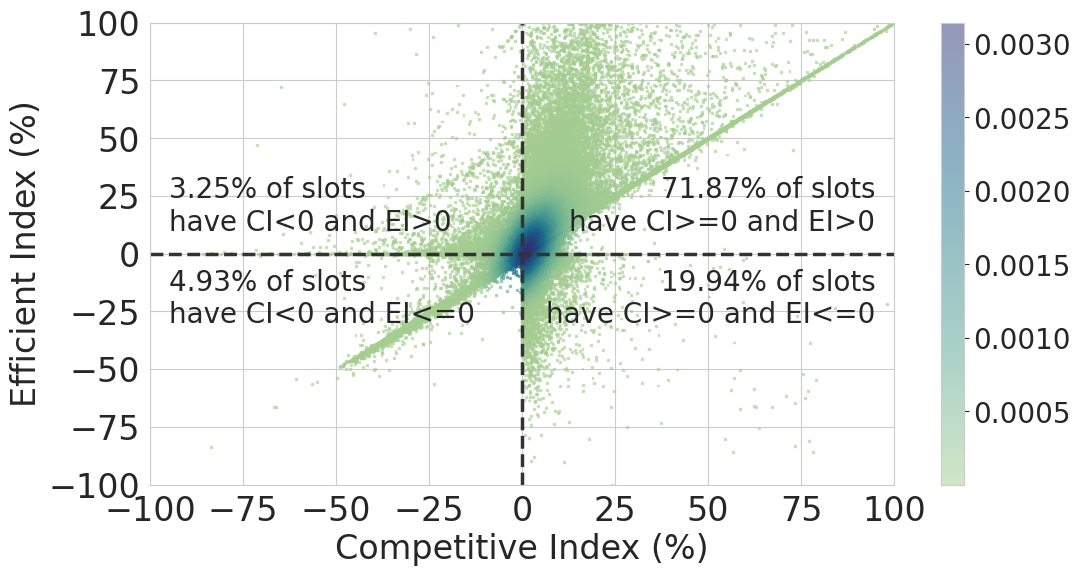

In [7]:
# This step may take some time (~10 minutes)
from scipy.stats import gaussian_kde

z = gaussian_kde(slot_count_df[["CI", "EI"]].T)
zz = z(slot_count_df[["CI", "EI"]].T)

plt.figure(figsize=(12, 6), dpi=100)
sns.set_style(style="whitegrid")
ax = plt.scatter(slot_count_df["CI"], slot_count_df["EI"], c=zz, cmap=sns.color_palette("crest", as_cmap=True), s=2, alpha=0.5, marker=',')
cbar = plt.colorbar(ax)
cbar.ax.tick_params(labelsize=20)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.xlabel("Competitive Index (%)", fontsize=24)
plt.ylabel("Efficient Index (%)", fontsize=24)
plt.axhline(y=0, color='#333333', linestyle='--', linewidth=2.5)
plt.axvline(x=0, color='#333333', linestyle='--', linewidth=2.5)


a1 = 100 * slot_count_df[(slot_count_df["CI"]>=0)&(slot_count_df["EI"]>0)].shape[0]/slot_count_df.shape[0]
a2 = 100 * slot_count_df[(slot_count_df["CI"]<0)&(slot_count_df["EI"]<=0)].shape[0]/slot_count_df.shape[0]
a3 = 100 * slot_count_df[(slot_count_df["CI"]>=0)&(slot_count_df["EI"]<=0)].shape[0]/slot_count_df.shape[0]
a4 = 100 * slot_count_df[(slot_count_df["CI"]<0)&(slot_count_df["EI"]>0)].shape[0]/slot_count_df.shape[0]
plt.text(95, 10, f"{a1:.2f}% of slots\nhave CI>=0 and EI>0", fontsize=20, ha='right')
plt.text(-95, -30, f"{a2:.2f}% of slots\nhave CI<0 and EI<=0", fontsize=20, ha='left')
plt.text(95, -30, f"{a3:.2f}% of slots\nhave CI>=0 and EI<=0", fontsize=20, ha='right')
plt.text(-95, 10, f"{a4:.2f}% of slots\nhave CI<0 and EI>0", fontsize=20, ha='left')
plt.savefig("images/ci-ei.pdf", bbox_inches="tight")
plt.show()

Plotting Figure 10: CDF of the winning bid value of auction dataset.

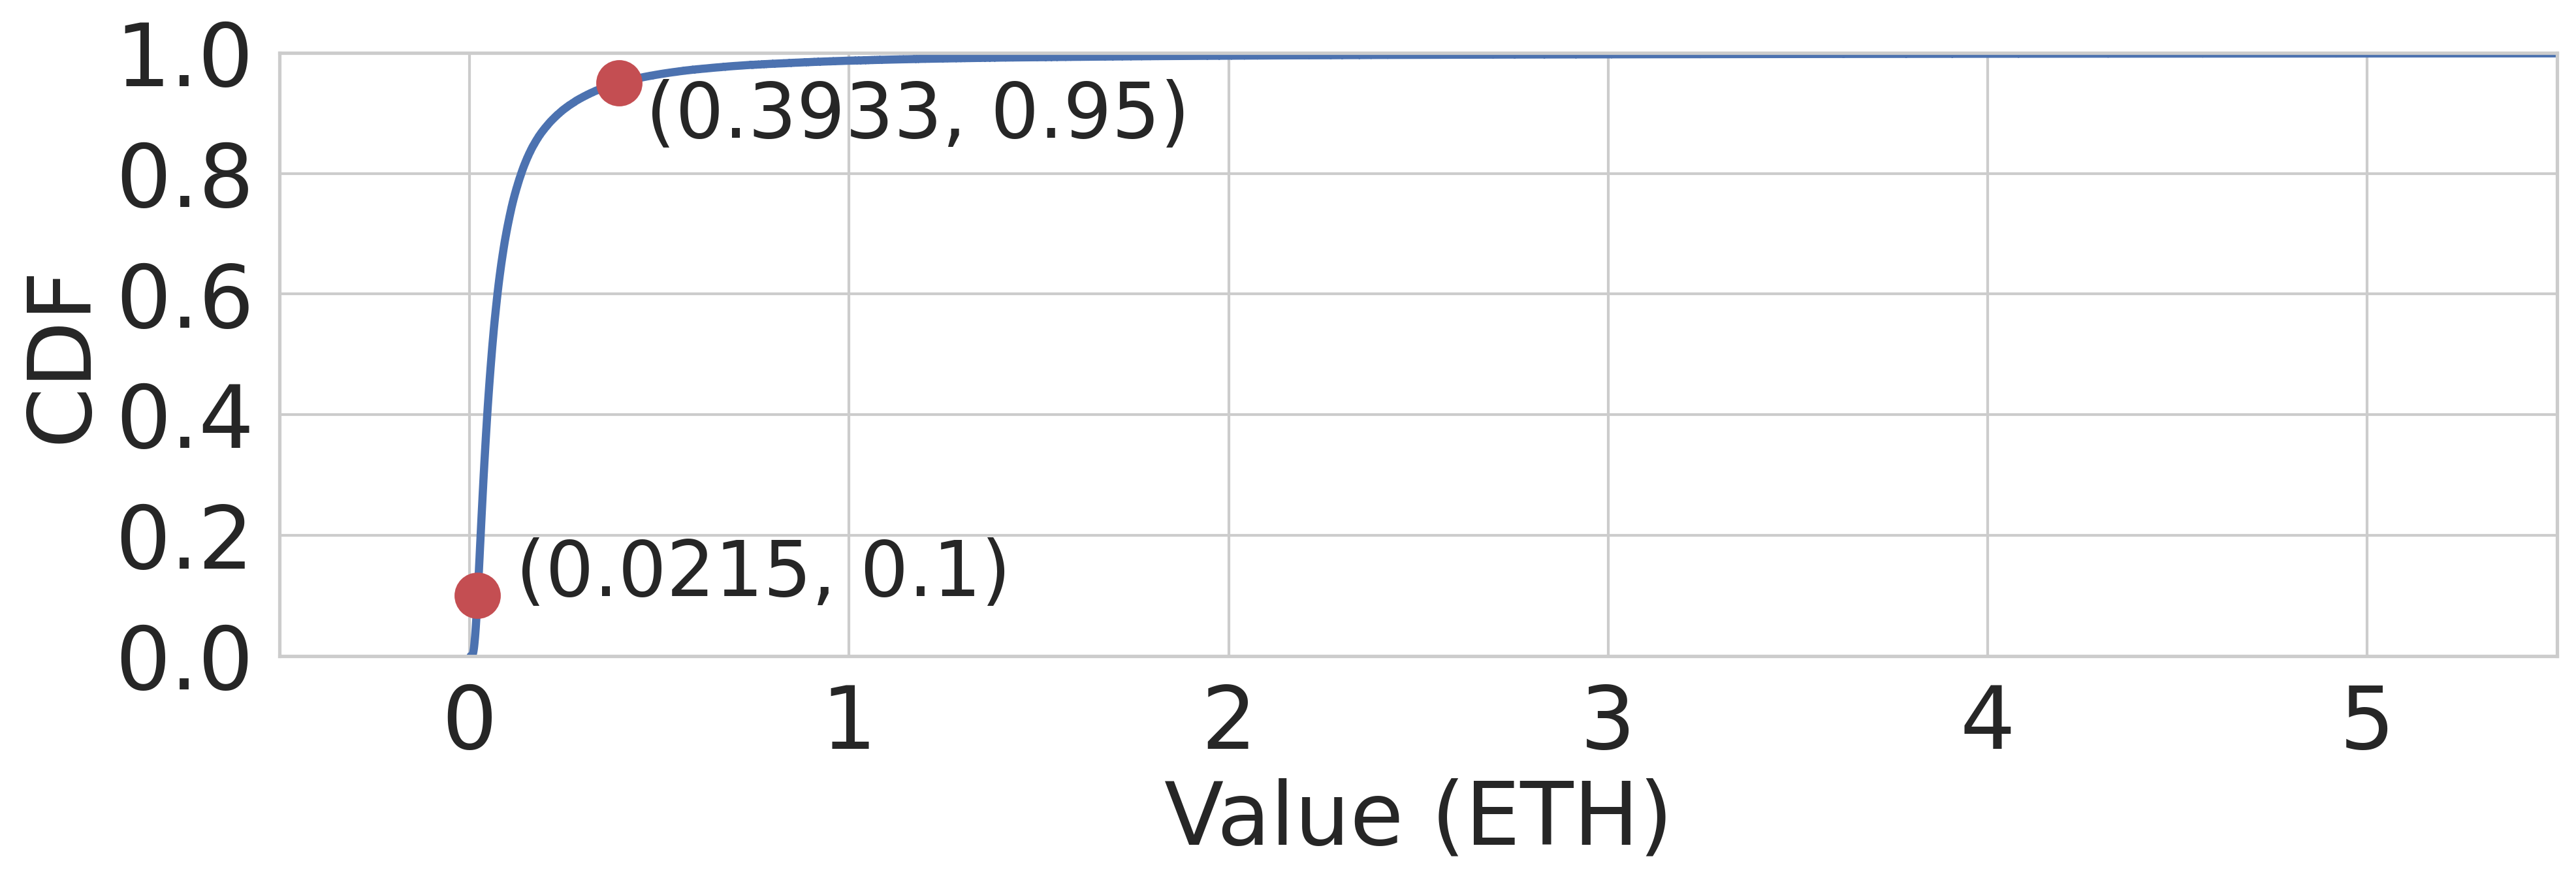

In [10]:
slots = slot_count_df["slot"].unique()
bids_df = blocks_df[blocks_df["slot"].isin(slots)].reindex()
p1, p2 = bids_df["bid_value"].quantile([0.1, 0.95]).values

plt.figure(figsize=(15, 4), dpi=300)
sns.set_style("whitegrid")
sns.ecdfplot(data=bids_df, x="bid_value", linewidth=3)
plt.xlim(-0.5, 5.5)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel("Value (ETH)", fontsize=32)
plt.ylabel("CDF", fontsize=32)
plt.plot(p1, 0.1, 'ro', markersize=16)
plt.plot(p2, 0.95, 'ro', markersize=16)
plt.annotate(f'({p1:.4f}, 0.1)', (p1, 0.1), textcoords="offset points", xytext=(105,0), ha='center', fontsize=28)
plt.annotate(f'({p2:.4f}, 0.95)', (p2, 0.95), textcoords="offset points", xytext=(110,-20), ha='center', fontsize=28)
plt.savefig("images/value_distribution.pdf", bbox_inches="tight")
plt.show()

Table 4: The percentages of blocks and MEV-Boost blocks built by each builder from April to December 2023.

In [11]:
# Market share of top-25 builders (April 2023 - December 2023)
sub_blocks_df = blocks_df[(blocks_df["number"]>=16730072)&(blocks_df["number"]<=18908894)].reindex()
mev_boost_blocks_df = sub_blocks_df[~sub_blocks_df["builder_pubkey"].isna()].reindex()
mev_boost_blocks_df

mev_boost_blocks_df["builder"] = mev_boost_blocks_df["builder_pubkey"].apply(lambda x: builders.get(x, x[:12]))
total_block_num = sub_blocks_df.shape[0]
total_mev_block_num = mev_boost_blocks_df.shape[0]

grouped_builder_df = mev_boost_blocks_df.groupby('builder').size().reset_index(name='count')
top25_builders = grouped_builder_df.sort_values(by='count', ascending=False).head(25)
print("Builder, \% of total blocks \% of MEV-Boost blocks")
for builder, count in top25_builders.values:
    print(f"{builder}, {100*count/total_block_num:.2f}, {100*count/total_mev_block_num:.2f}")

Builder, \% of total blocks \% of MEV-Boost blocks
beaverbuild, 22.53, 24.69
rsync-builder, 20.75, 22.74
builder0x69, 12.65, 13.86
Titan, 12.35, 13.53
Flashbots, 12.24, 13.42
bloXroute, 2.14, 2.34
f1b.io, 1.66, 1.81
Blocknative, 1.40, 1.53
eth-builder, 0.77, 0.84
BuildAI, 0.73, 0.80
Gambit Labs, 0.64, 0.70
jetbldr.xyz, 0.47, 0.51
manta-builder, 0.46, 0.51
payload.de, 0.39, 0.42
boba-builder.com, 0.27, 0.30
penguinbuild.org, 0.23, 0.25
Eden, 0.22, 0.24
lightspeedbuilder, 0.21, 0.23
0x3bee5122e2a2fbe11287aafb0cb918e22abb5436, 0.16, 0.18
lokibuilder.xyz, 0.12, 0.13
bobTheBuilder.xyz, 0.11, 0.13
blockbeelder.com, 0.11, 0.12
finest artisanal blocks, 0.09, 0.10
It's Free Real Estate, 0.08, 0.09
nfactorial.xyz, 0.06, 0.07


Figure 5: The ratio of auctions that are competitive and efficient across various MEV tiers.

In [11]:
def get_cv(data):
    return np.std(data) / np.mean(data)

def quartile_coefficient_of_dispersion(array):
    q75, q25 = np.percentile(array, [75 ,25])
    return (q75 - q25) / (q75 + q25)

# MEV tier
def get_range(x):
    if x <= 0.0215:
        return "Low MEV"
    elif x <= 0.3933:
        return "Medium MEV"
    else:
        return "High MEV"

slot_count_df["Tier"] = slot_count_df["value"].apply(get_range)

# Builder market share (April 2023 - December 2023)
top_builders = set(['beaverbuild', 'rsync-builder', 'builder0x69', 'Flashbots', 'Titan'])
middle_builders = set([
    'bloXroute',
    'f1b.io',
    'Blocknative',
    'eth-builder',
    'BuildAI',
    'Gambit Labs',
    'jetbldr.xyz',
    'manta-builder',
    'payload.de',
    'boba-builder.com'
])
bottom_builders = set([
    'penguinbuild.org',
    'Eden',
    'lightspeedbuilder',
    '0x3bee5122e2a2fbe11287aafb0cb918e22abb5436',
    'lokibuilder.xyz',
    'bobTheBuilder.xyz',
    'blockbeelder.com',
    'finest artisanal blocks',
    "It's Free Real Estate",
    'nfactorial.xyz'
])

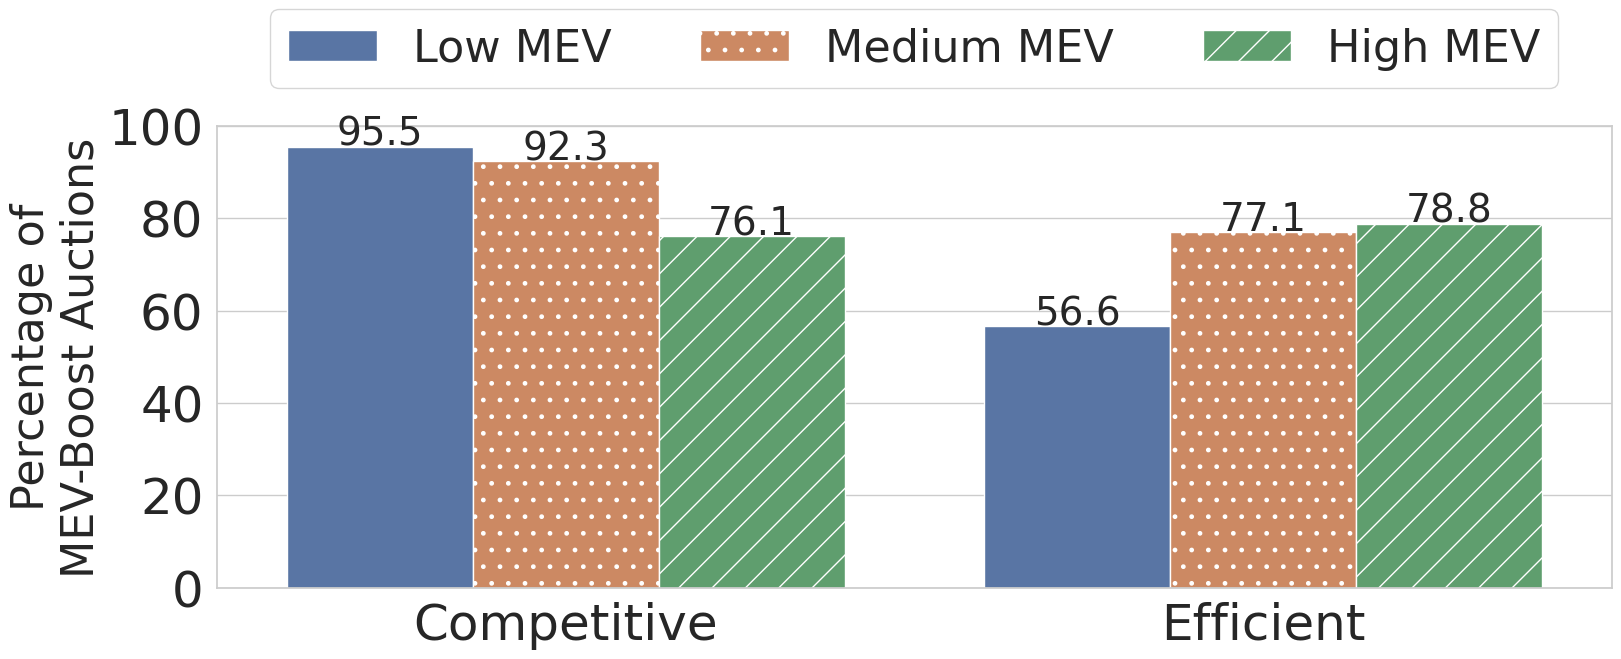

In [13]:
plt.figure(figsize=(18, 6), dpi=100)
sns.set_style(style="whitegrid")

data = []
for tier, sub_df in slot_count_df.groupby("Tier"):
    competitive_df = sub_df[sub_df["CI"]>=0]
    competitive_count = competitive_df.shape[0]
    data.append([tier, f"Competitive", competitive_count*100/sub_df.shape[0]])
    efficient_df = sub_df[sub_df["EI"]>0]
    efficient_count = efficient_df.shape[0]
    data.append([tier, f"Efficient", efficient_count*100/sub_df.shape[0]])

df = pd.DataFrame(data, columns=["Tier", "Type", "Percentage"])
ax = sns.barplot(data=df, x="Type", y="Percentage", hue="Tier", order=["Competitive", "Efficient"], hue_order=["Low MEV", "Medium MEV", "High MEV"])
for bars, hatch in zip(ax.containers, ['', '.', '/']):
    for bar in bars:
        if hatch != '':
            bar.set_hatch(hatch)

for p in ax.patches[:6]:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points', fontsize=28)
    
handles, labels = ax.get_legend_handles_labels()
handles[1].set_hatch('.')
handles[2].set_hatch('/')
ax.legend(handles=handles, labels=["Low MEV", "Medium MEV", "High MEV"])
sns.move_legend(ax, "upper center", fontsize=32, ncol=3, title=None, bbox_to_anchor=(0.5, 1.3))
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.xlabel(None)
plt.ylim(0, 100)
plt.ylabel("Percentage of\nMEV-Boost Auctions", fontsize=32)
plt.savefig("images/ci-ei-mev-bar.pdf", bbox_inches="tight")
plt.show()

Figure 6 (11): Violin graphs for the distribution of the QCD (CV) across three MEV tiers, for top, middle, and tail builders. 

In [14]:
slot_to_value = dict(zip(slot_count_df["slot"].values, slot_count_df["value"].values))

processed_data = []
for f in file_pathes:
    if f.startswith("capability"):
        data = pd.read_csv(os.path.join(INDEX_DATA_PATH, f))
        for slot, slot_df in data.groupby("slot"):
            builder_to_true_value = dict(zip(slot_df["builder"].values, slot_df["true_value"].values))

            top_builder_values = [v for k, v in builder_to_true_value.items() if k in top_builders and v > 0] 
            middle_builder_values = [v for k, v in builder_to_true_value.items() if k in middle_builders and v > 0]
            tail_builder_values = [v for k, v in builder_to_true_value.items() if k in bottom_builders and v > 0]

            if len(top_builder_values) > 1:
                top_cv = get_cv(top_builder_values)
                top_qcd = quartile_coefficient_of_dispersion(top_builder_values)
            
            if len(middle_builder_values) > 1:
                middle_cv = get_cv(middle_builder_values)
                middle_qcd = quartile_coefficient_of_dispersion(middle_builder_values)

            if len(tail_builder_values) > 1:
                tail_cv = get_cv(tail_builder_values)
                tail_qcd = quartile_coefficient_of_dispersion(tail_builder_values)

            value = slot_to_value.get(slot, None)
            if value is None:
                value = max(top_builder_values + middle_builder_values + tail_builder_values)

            processed_data.append((slot, value, top_cv, middle_cv, tail_cv, top_qcd, middle_qcd, tail_qcd))

data_df = pd.DataFrame(processed_data, columns=["slot", "max_value", "top_cv", "middle_cv", "tail_cv", "top_qcd", "middle_qcd", "tail_qcd"])
data_df["Tier"] = data_df["max_value"].apply(get_range)

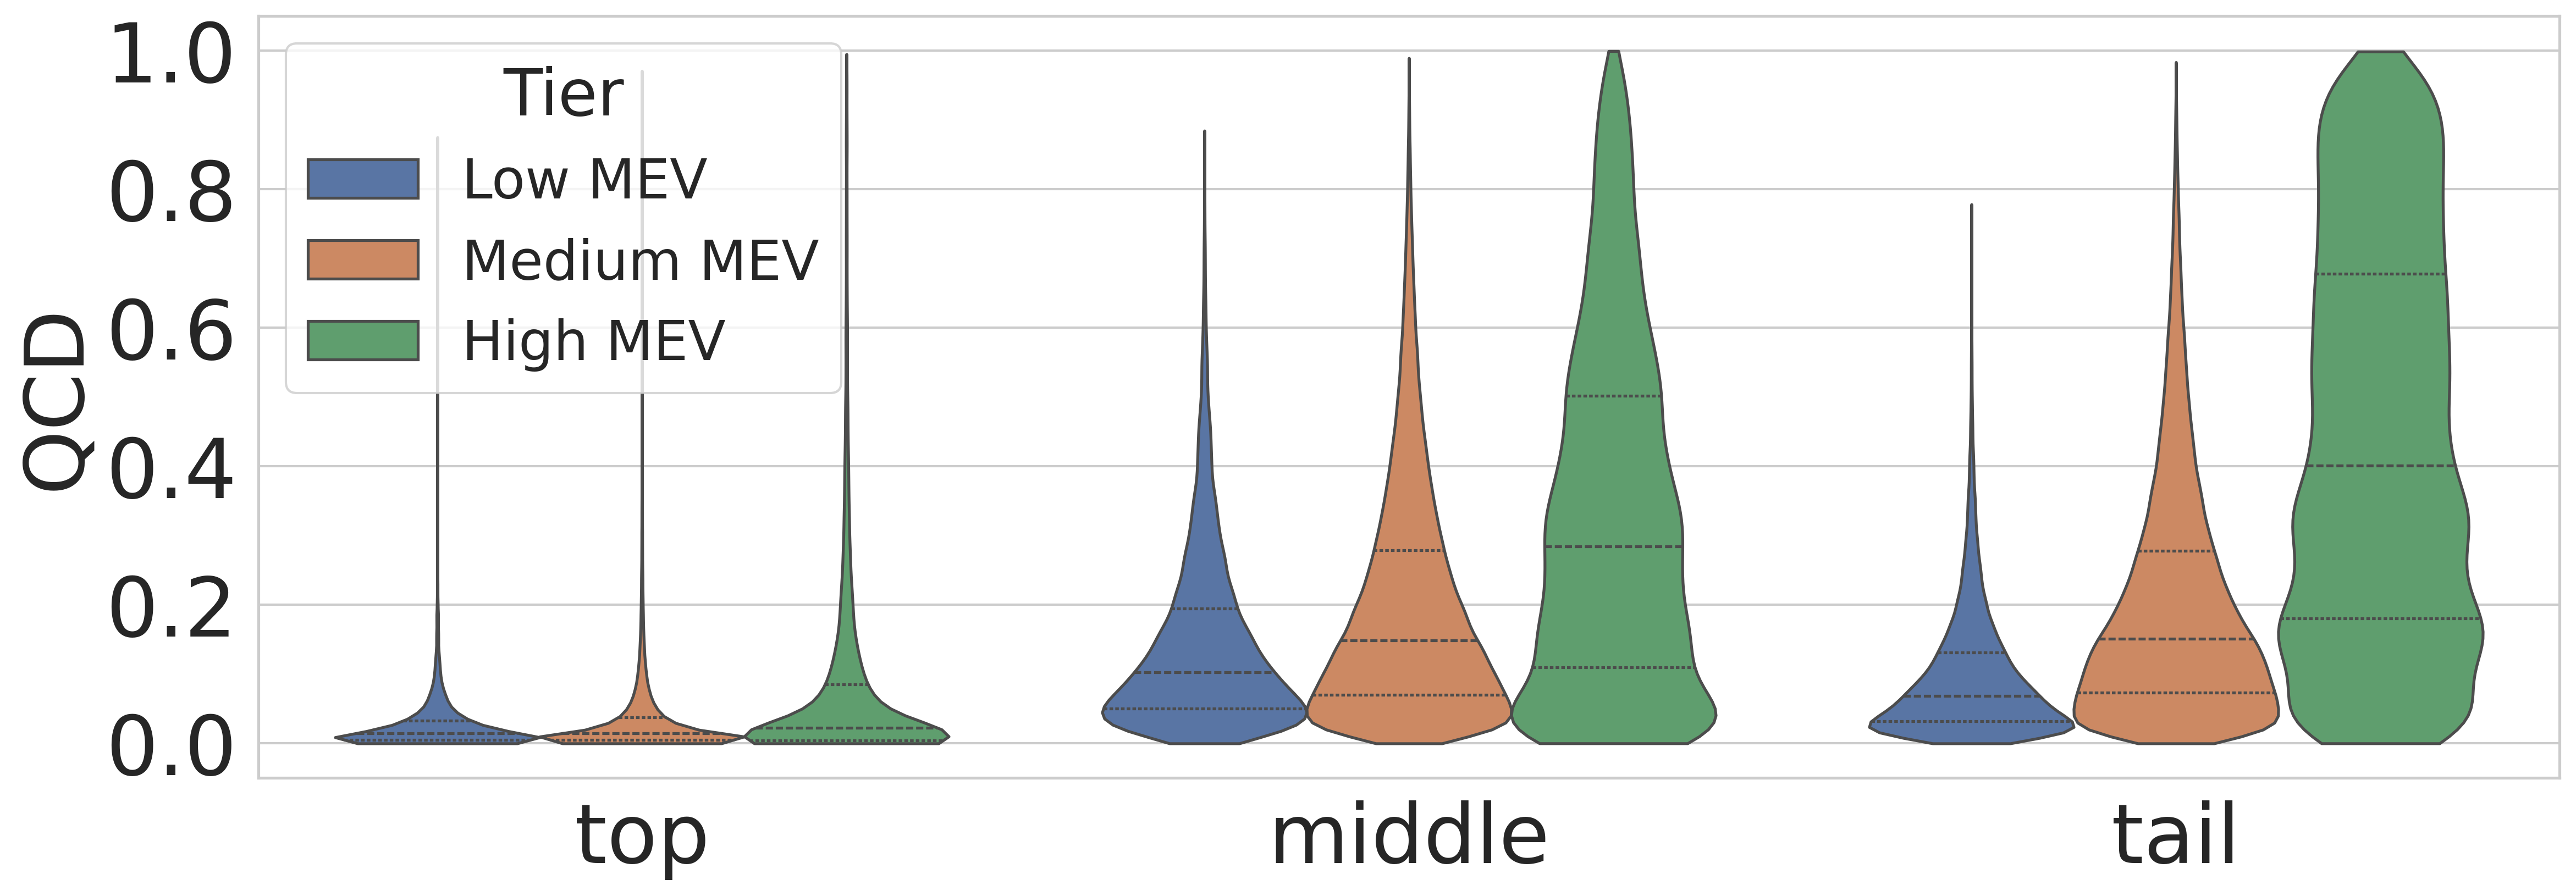

In [18]:
all_data_df = pd.melt(data_df, id_vars=["slot", "Tier"], value_vars=["top_qcd", "middle_qcd", "tail_qcd"], var_name="K", value_name="qcd")
df_cleaned = all_data_df.dropna()
df_cleaned["K"] = df_cleaned["K"].str.split("_").str[0]

plt.figure(figsize=(18, 6), dpi=300)
sns.set_style("whitegrid")
ax = sns.violinplot(data=df_cleaned, y="qcd", x="K", hue="Tier", cut=0, density_norm="width", inner="quartile", hue_order=["Low MEV", "Medium MEV", "High MEV"])
sns.move_legend(ax, "upper left", title_fontsize=28, fontsize=24)
plt.xlabel(None)
plt.ylim(-0.05, 1.05)
plt.ylabel("QCD", fontsize=36)
plt.yticks(fontsize=36)
plt.xticks(fontsize=36)
plt.savefig("images/qcd-mev.pdf", bbox_inches="tight")
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                              

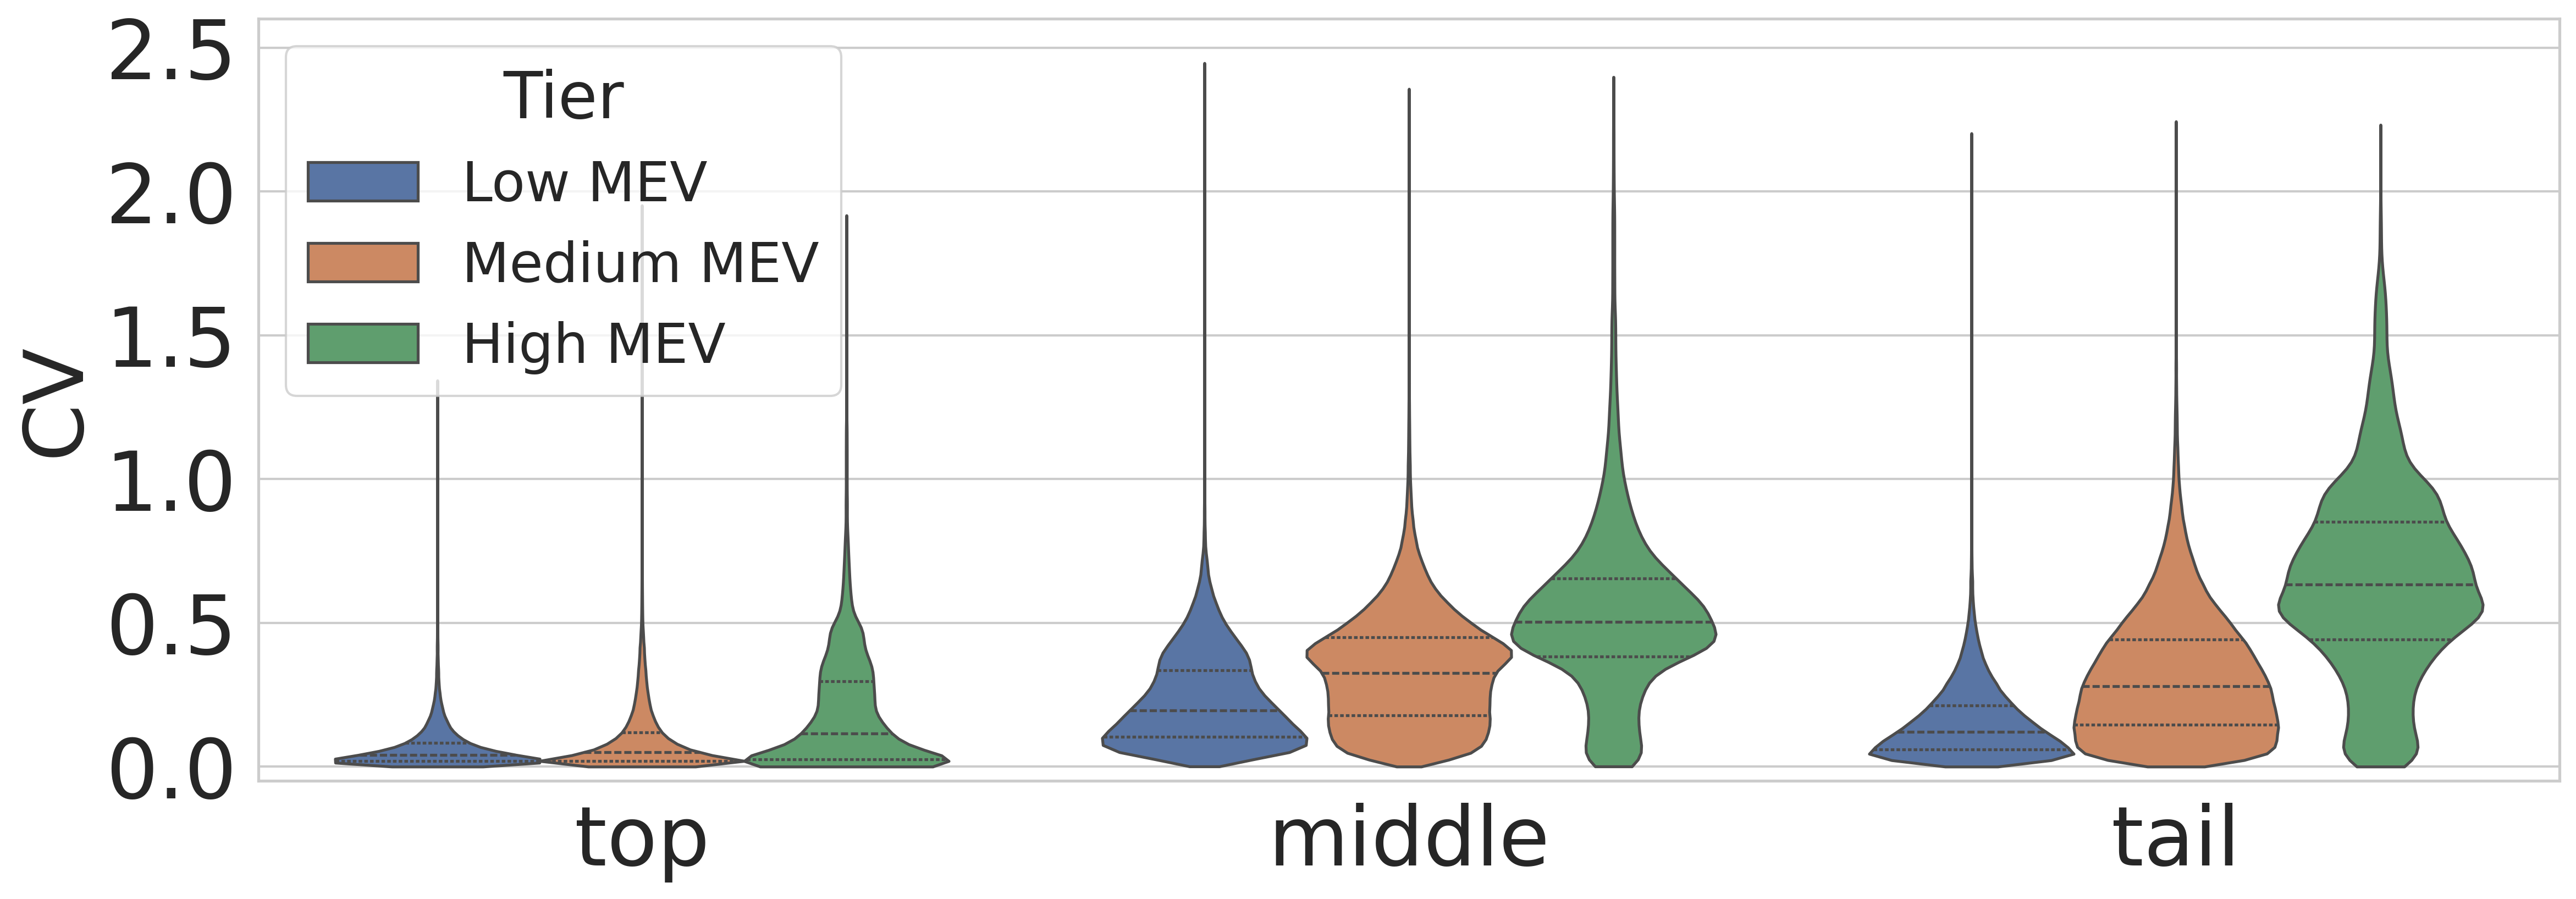

In [19]:
all_data_df = pd.melt(data_df, id_vars=["slot", "Tier"], value_vars=["top_cv", "middle_cv", "tail_cv"], var_name="K", value_name="cv")
df_cleaned = all_data_df.dropna()
df_cleaned["K"] = df_cleaned["K"].str.split("_").str[0]
plt.figure(figsize=(18, 6), dpi=300)
sns.set_style("whitegrid")
ax = sns.violinplot(data=df_cleaned, y="cv", x="K", hue="Tier", cut=0, density_norm="width", inner="quartile", hue_order=["Low MEV", "Medium MEV", "High MEV"])
sns.move_legend(ax, "upper left", title_fontsize=28, fontsize=24)
plt.xlabel(None)
plt.ylim(-0.05, 2.6)
plt.ylabel("CV", fontsize=36)
plt.yticks(fontsize=36)
plt.xticks(fontsize=36)
plt.savefig("images/cv-mev.pdf", bbox_inches="tight")
plt.show()

Figure 12: The distribution of the CIs of MEV-Boost auctions

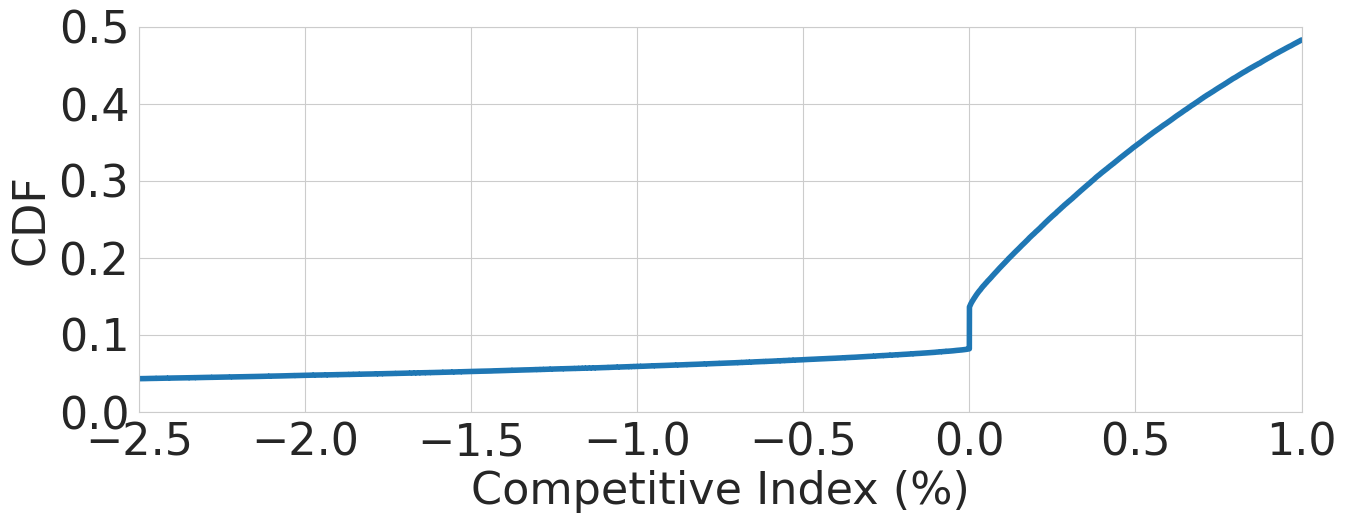

In [76]:
plt.figure(figsize=(15, 5), dpi=100)
sns.set_style(style="whitegrid")
ax = sns.ecdfplot(data=slot_count_df, x="CI", linewidth=4)
plt.xlabel("Competitive Index (%)", fontsize=32)
plt.ylabel("CDF", fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlim(-2.5, 1)
plt.ylim(0, 0.5)
plt.savefig("images/ci-cdf.pdf", bbox_inches="tight")
plt.show()

In [20]:
subsidy_count = []
hide_count = []
for file_path in file_pathes:
    if file_path.endswith("json"):
        month = file_path[:6]
        with open(os.path.join(INDEX_DATA_PATH, file_path), "r") as f:
            data = json.load(f)
        for item in data["subsidy_count"]:
            subsidy_count.append(item[0])
        for item in data["hide_count"]:
            hide_count.append(item[0])

inefficient_count = slot_count_df[slot_count_df["EI"]<=0].shape[0]
print(f"Inefficiency caused by subsidy: {len(subsidy_count)*100/inefficient_count:.2f}%")
print(f"Inefficiency caused by bid shading: {len(hide_count)*100/inefficient_count:.2f}%")

for tier, tier_df in slot_count_df.groupby("Tier"):
    print(f"Tier: {tier}")
    tier_shape = tier_df[tier_df["EI"]<=0].shape[0]
    tier_slots = tier_df["slot"].unique()
    print(f"Inefficiency caused by subsidy: {100*len(set(subsidy_count)&set(tier_slots))/tier_shape:.2f}%")
    print(f"Inefficiency caused by bid shading: {100*len(set(hide_count)&set(tier_slots))/tier_shape:.2f}%")

Inefficiency caused by subsidy: 60.98%
Inefficiency caused by bid shading: 48.00%
Tier: High MEV
Inefficiency caused by subsidy: 18.28%
Inefficiency caused by bid shading: 85.55%
Tier: Low MEV
Inefficiency caused by subsidy: 81.19%
Inefficiency caused by bid shading: 34.48%
Tier: Medium MEV
Inefficiency caused by subsidy: 58.73%
Inefficiency caused by bid shading: 49.01%


Table 2: Losses from uncompetitiveness and inequality.

In [8]:
value_count = []
for file_path in file_pathes:
    if file_path.endswith("json"):
        month = file_path[:6]
        with open(os.path.join(INDEX_DATA_PATH, file_path), "r") as f:
            data = json.load(f)

        for slot, winner_bid_value, winner_true_value, second_highest_true_value, highest_true_value in data["value_count"]:
            value_count.append([month, slot, winner_bid_value, winner_true_value, second_highest_true_value, highest_true_value])

uncompetitive_slots = slot_count_df[slot_count_df["CI"]<0]["slot"].unique()
profit_df = pd.DataFrame(value_count, columns=["month", "slot", "winner_bid_value", "winner_true_value", "second_highest_true_value", "highest_true_value"])
profit_df = profit_df[profit_df["highest_true_value"]<=1e28].reindex()
profit_df["inequality_loss"] = profit_df["highest_true_value"] - profit_df["second_highest_true_value"]
profit_df["uncompetitiveness_loss"] = profit_df["second_highest_true_value"] - profit_df["winner_bid_value"]

slot_num = profit_df.shape[0]
total_bid_value = profit_df["winner_bid_value"].sum()/1e18
subsub_df = profit_df[profit_df["slot"].isin(uncompetitive_slots)].reindex()
uncompetitive_slot_num = subsub_df.shape[0]
loss_from_inequality = profit_df["inequality_loss"].sum()/1e18
loss_from_uncompetitiveness = subsub_df["uncompetitiveness_loss"].sum()/1e18
print(f"all: {slot_num} slots, {uncompetitive_slot_num} uncompetitive slots ({100*uncompetitive_slot_num/slot_num:.2f}\%), {total_bid_value:.2f} ETH,  {loss_from_uncompetitiveness:.2f} ETH ({100*loss_from_uncompetitiveness/total_bid_value:.2f}\%) from uncompetitiveness, {loss_from_inequality:.2f} ETH ({100*loss_from_inequality/total_bid_value:.2f}\%) from inequality")


for month, sub_df in profit_df.groupby("month"):
    slot_num = sub_df.shape[0]
    total_bid_value = sub_df["winner_bid_value"].sum()/1e18
    subsub_df = sub_df[sub_df["slot"].isin(uncompetitive_slots)].reindex()
    uncompetitive_slot_num = subsub_df.shape[0]
    subsub_df["loss"] = subsub_df["second_highest_true_value"] - subsub_df["winner_bid_value"]
    total_loss = subsub_df["loss"].sum()/1e18
    loss_from_inequality = sub_df["inequality_loss"].sum()/1e18
    print(f"{month}: {slot_num} slots, {uncompetitive_slot_num} uncompetitive slots ({100*uncompetitive_slot_num/slot_num:.1f}\%), {total_bid_value:.1f} ETH,  {total_loss:.1f} ({100*total_loss/total_bid_value:.1f}\%) from uncompetitiveness, {loss_from_inequality:.1f} ({100*loss_from_inequality/total_bid_value:.1f}\%) from inequality")

all: 301479 slots, 24686 uncompetitive slots (8.19\%), 40439.27 ETH,  422.28 ETH (1.04\%) from uncompetitiveness, 2718.27 ETH (6.72\%) from inequality
202304: 28385 slots, 1050 uncompetitive slots (3.7\%), 2704.4 ETH,  46.9 (1.7\%) from uncompetitiveness, 312.1 (11.5\%) from inequality
202305: 30300 slots, 6874 uncompetitive slots (22.7\%), 9331.7 ETH,  115.8 (1.2\%) from uncompetitiveness, 518.6 (5.6\%) from inequality
202306: 35443 slots, 2790 uncompetitive slots (7.9\%), 4341.8 ETH,  25.1 (0.6\%) from uncompetitiveness, 342.2 (7.9\%) from inequality
202307: 36040 slots, 1839 uncompetitive slots (5.1\%), 3938.8 ETH,  19.1 (0.5\%) from uncompetitiveness, 246.1 (6.2\%) from inequality
202308: 17831 slots, 1254 uncompetitive slots (7.0\%), 2135.5 ETH,  12.5 (0.6\%) from uncompetitiveness, 146.6 (6.9\%) from inequality
202309: 35815 slots, 5030 uncompetitive slots (14.0\%), 3939.5 ETH,  48.5 (1.2\%) from uncompetitiveness, 247.7 (6.3\%) from inequality
202310: 39131 slots, 1509 uncompeti

## What Caused Inequality in Block-building Capacities

Figure 7: Fraction of builder income from private order flows.

In [6]:
# Load private transactions dataset
private_txns_df = pd.read_parquet(PRIVATE_TRANSACTIONS_PATH)
private_txns_df["txn_fee"] = pd.to_numeric(private_txns_df["txn_fee"], errors="coerce")
block_private_order_flow_values = private_txns_df.groupby("blockNumber")["txn_fee"].sum().to_dict()

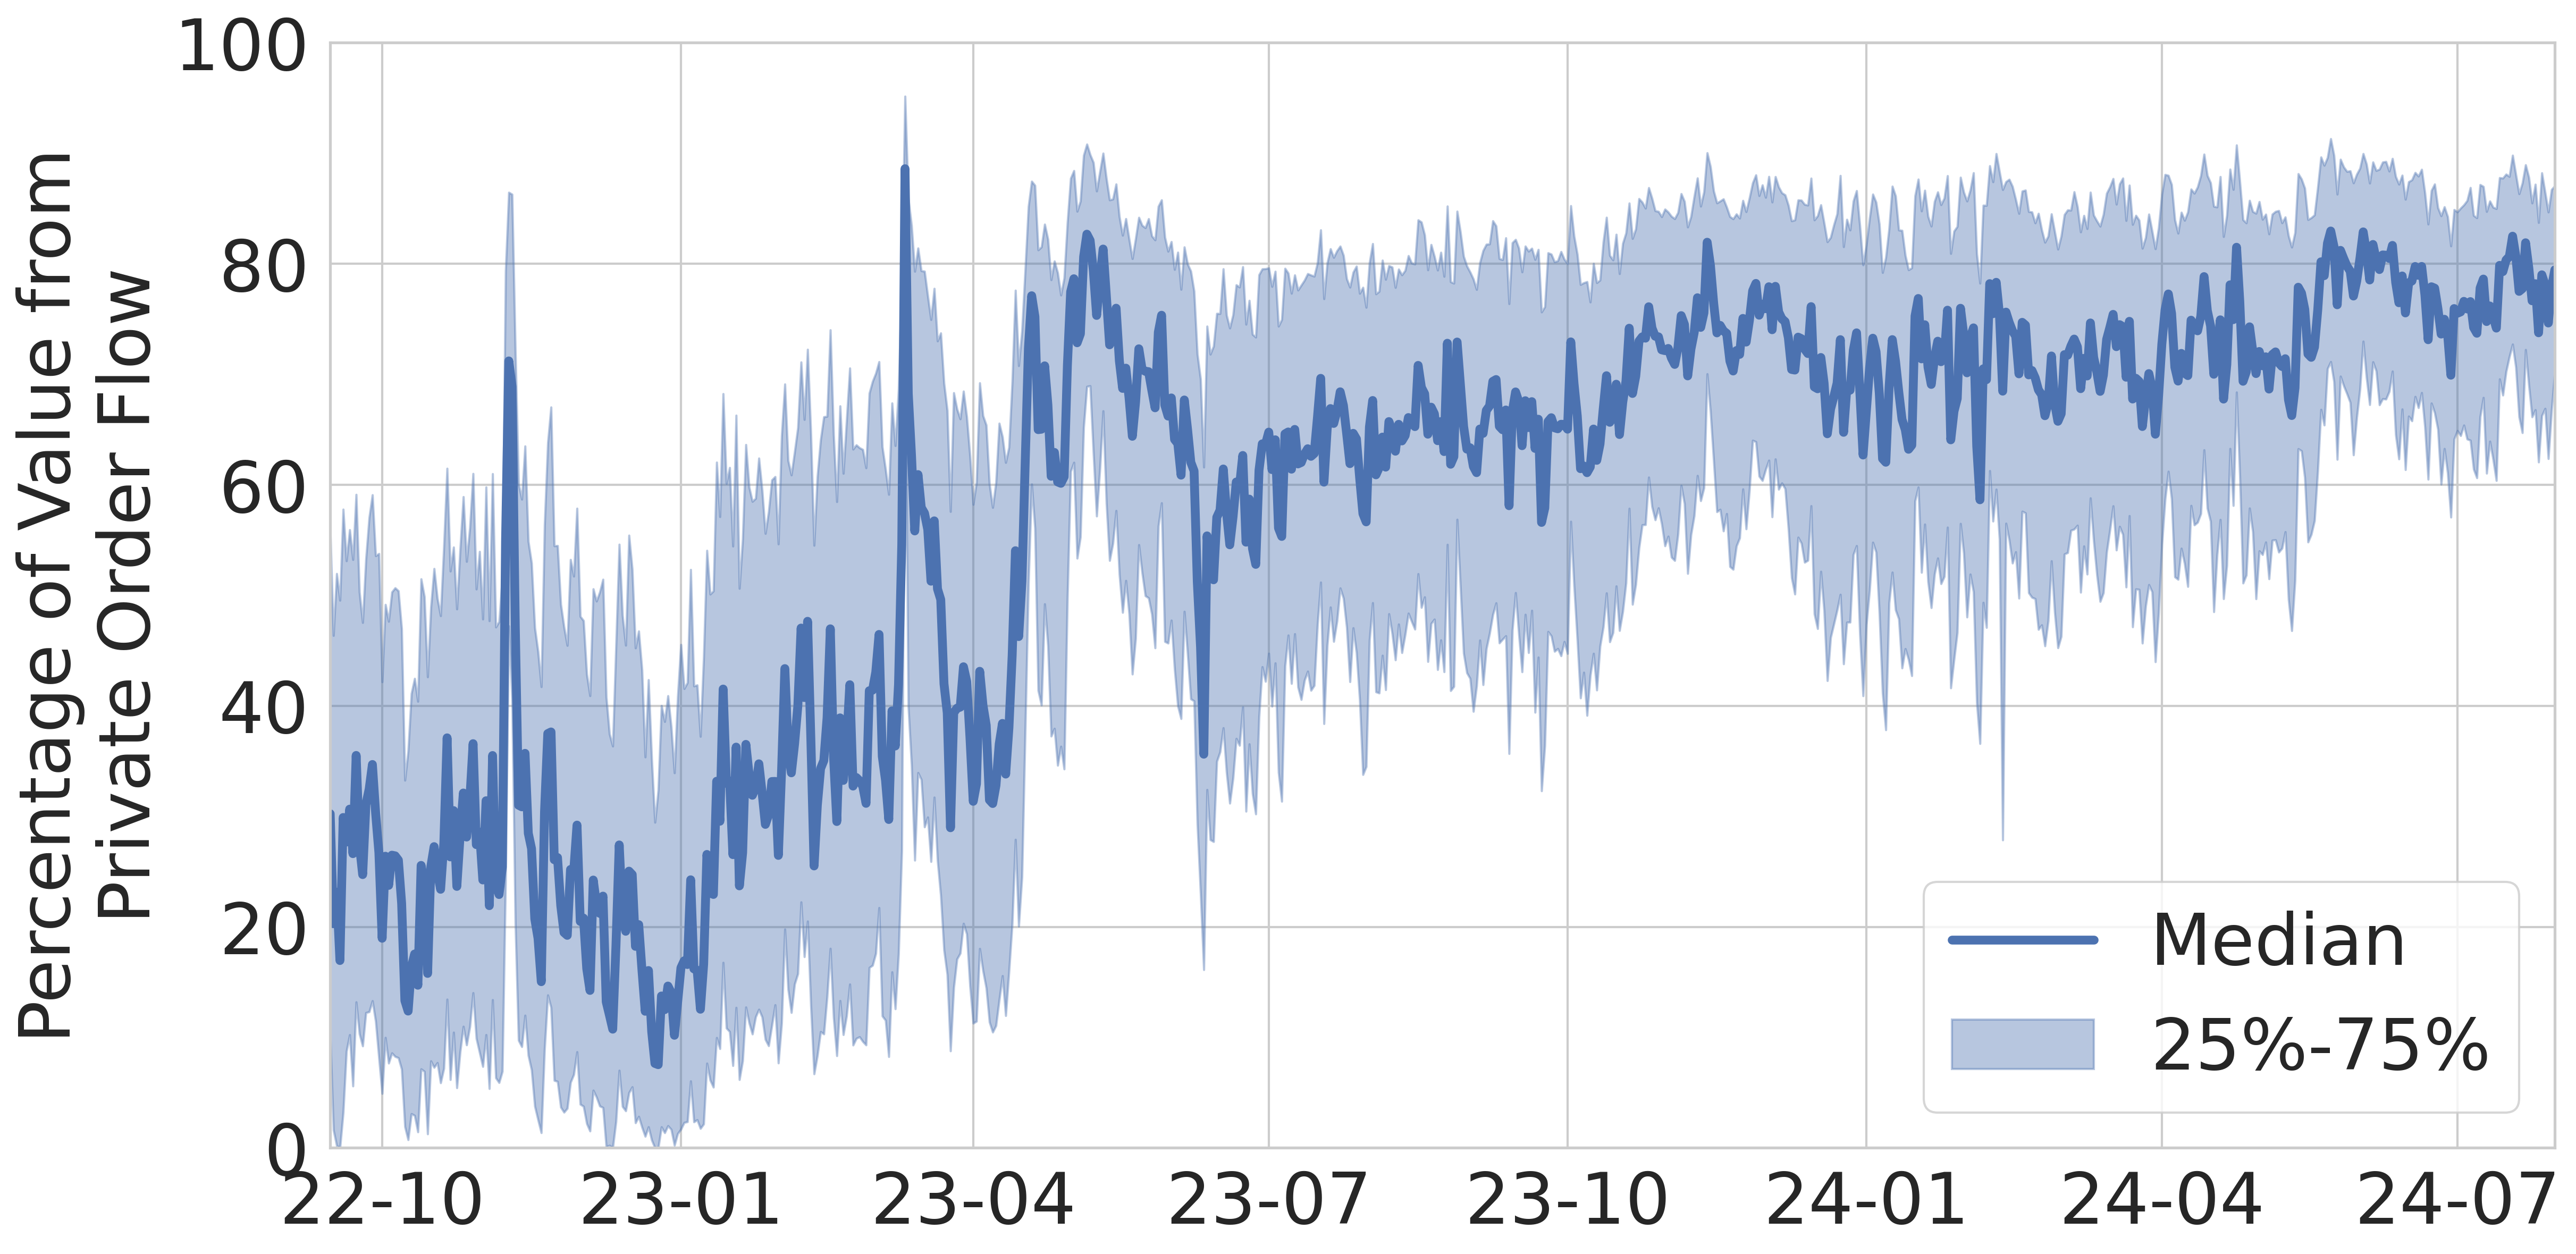

In [7]:
# Compute the private order flow percentage
data = []
for date_str, date_df in blocks_df.groupby("date"):
    sub_df = date_df[date_df["builder_pubkey"].notnull()].reindex()

    for block_number, bid_value, block_value in sub_df[["number", "bid_value", "block_value"]].values:
        if block_value == 0:
            data.append((date_str, block_number, bid_value,  0, 0, 0))
        else:
            private_order_flow_value = block_private_order_flow_values.get(block_number, 0)
            percentage =  100 * private_order_flow_value /1e18 / block_value
            data.append((date_str, block_number, bid_value, block_value, private_order_flow_value, percentage))


data_df = pd.DataFrame(data, columns=["date", "number", "bid_value", "block_value", "private_order_flow_value", "percentage"])
data_df['date'] = pd.to_datetime(data_df['date'])

percentiles = data_df.groupby('date')['percentage'].agg([lambda x: np.percentile(x, 50), lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)]).reset_index()
percentiles.columns = ['Date', 'Median', '25%', '75%']

import matplotlib as mpl
mpl.rcParams.clear()

plt.figure(figsize=(18, 9), dpi=300)
sns.set_theme(style="whitegrid")
default_blue = sns.color_palette("deep")[0]
ax = sns.lineplot(data=percentiles, x='Date', y='Median', label='Median', linewidth=4, color=default_blue)
plt.fill_between(percentiles['Date'], percentiles['25%'], percentiles['75%'], color=default_blue, alpha=0.4, label='25%-75%')
plt.yticks(fontsize=32)
plt.xlabel(None)
plt.ylabel('Percentage of Value from\nPrivate Order Flow', fontsize=32)

current_xticks, current_labels = plt.xticks(fontsize=28)
new_labels = []
for text in current_labels:
    if text.get_text()[:2] == "20":
        new_labels.append(text.get_text()[2:])
    else:
        new_labels.append(text.get_text())
plt.xticks(current_xticks, new_labels, fontsize=32)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=32, loc='lower right', title_fontsize=32)

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')
ax.set_xlim([start_date, end_date])
ax.set_ylim([0, 100])

plt.savefig("images/daily_private_order_flow.pdf", bbox_inches='tight')
plt.show()

## Pivotal Level

Figure 8: A provider P is pivotal if the winner of an auction could have lost without order flows from P. 

In [38]:
# load the pivotal providers data
con = sq.connect(PIVOTAL_BUILDERS_PATH)
pivotal_providers_df = pd.read_sql_query("SELECT * FROM pivotal_providers;", con)
con.close()

# parse provider names
def parse_provider(name):
    if name.startswith("Searcher: "):
        return name[:16] + "..."
    else:
        return name

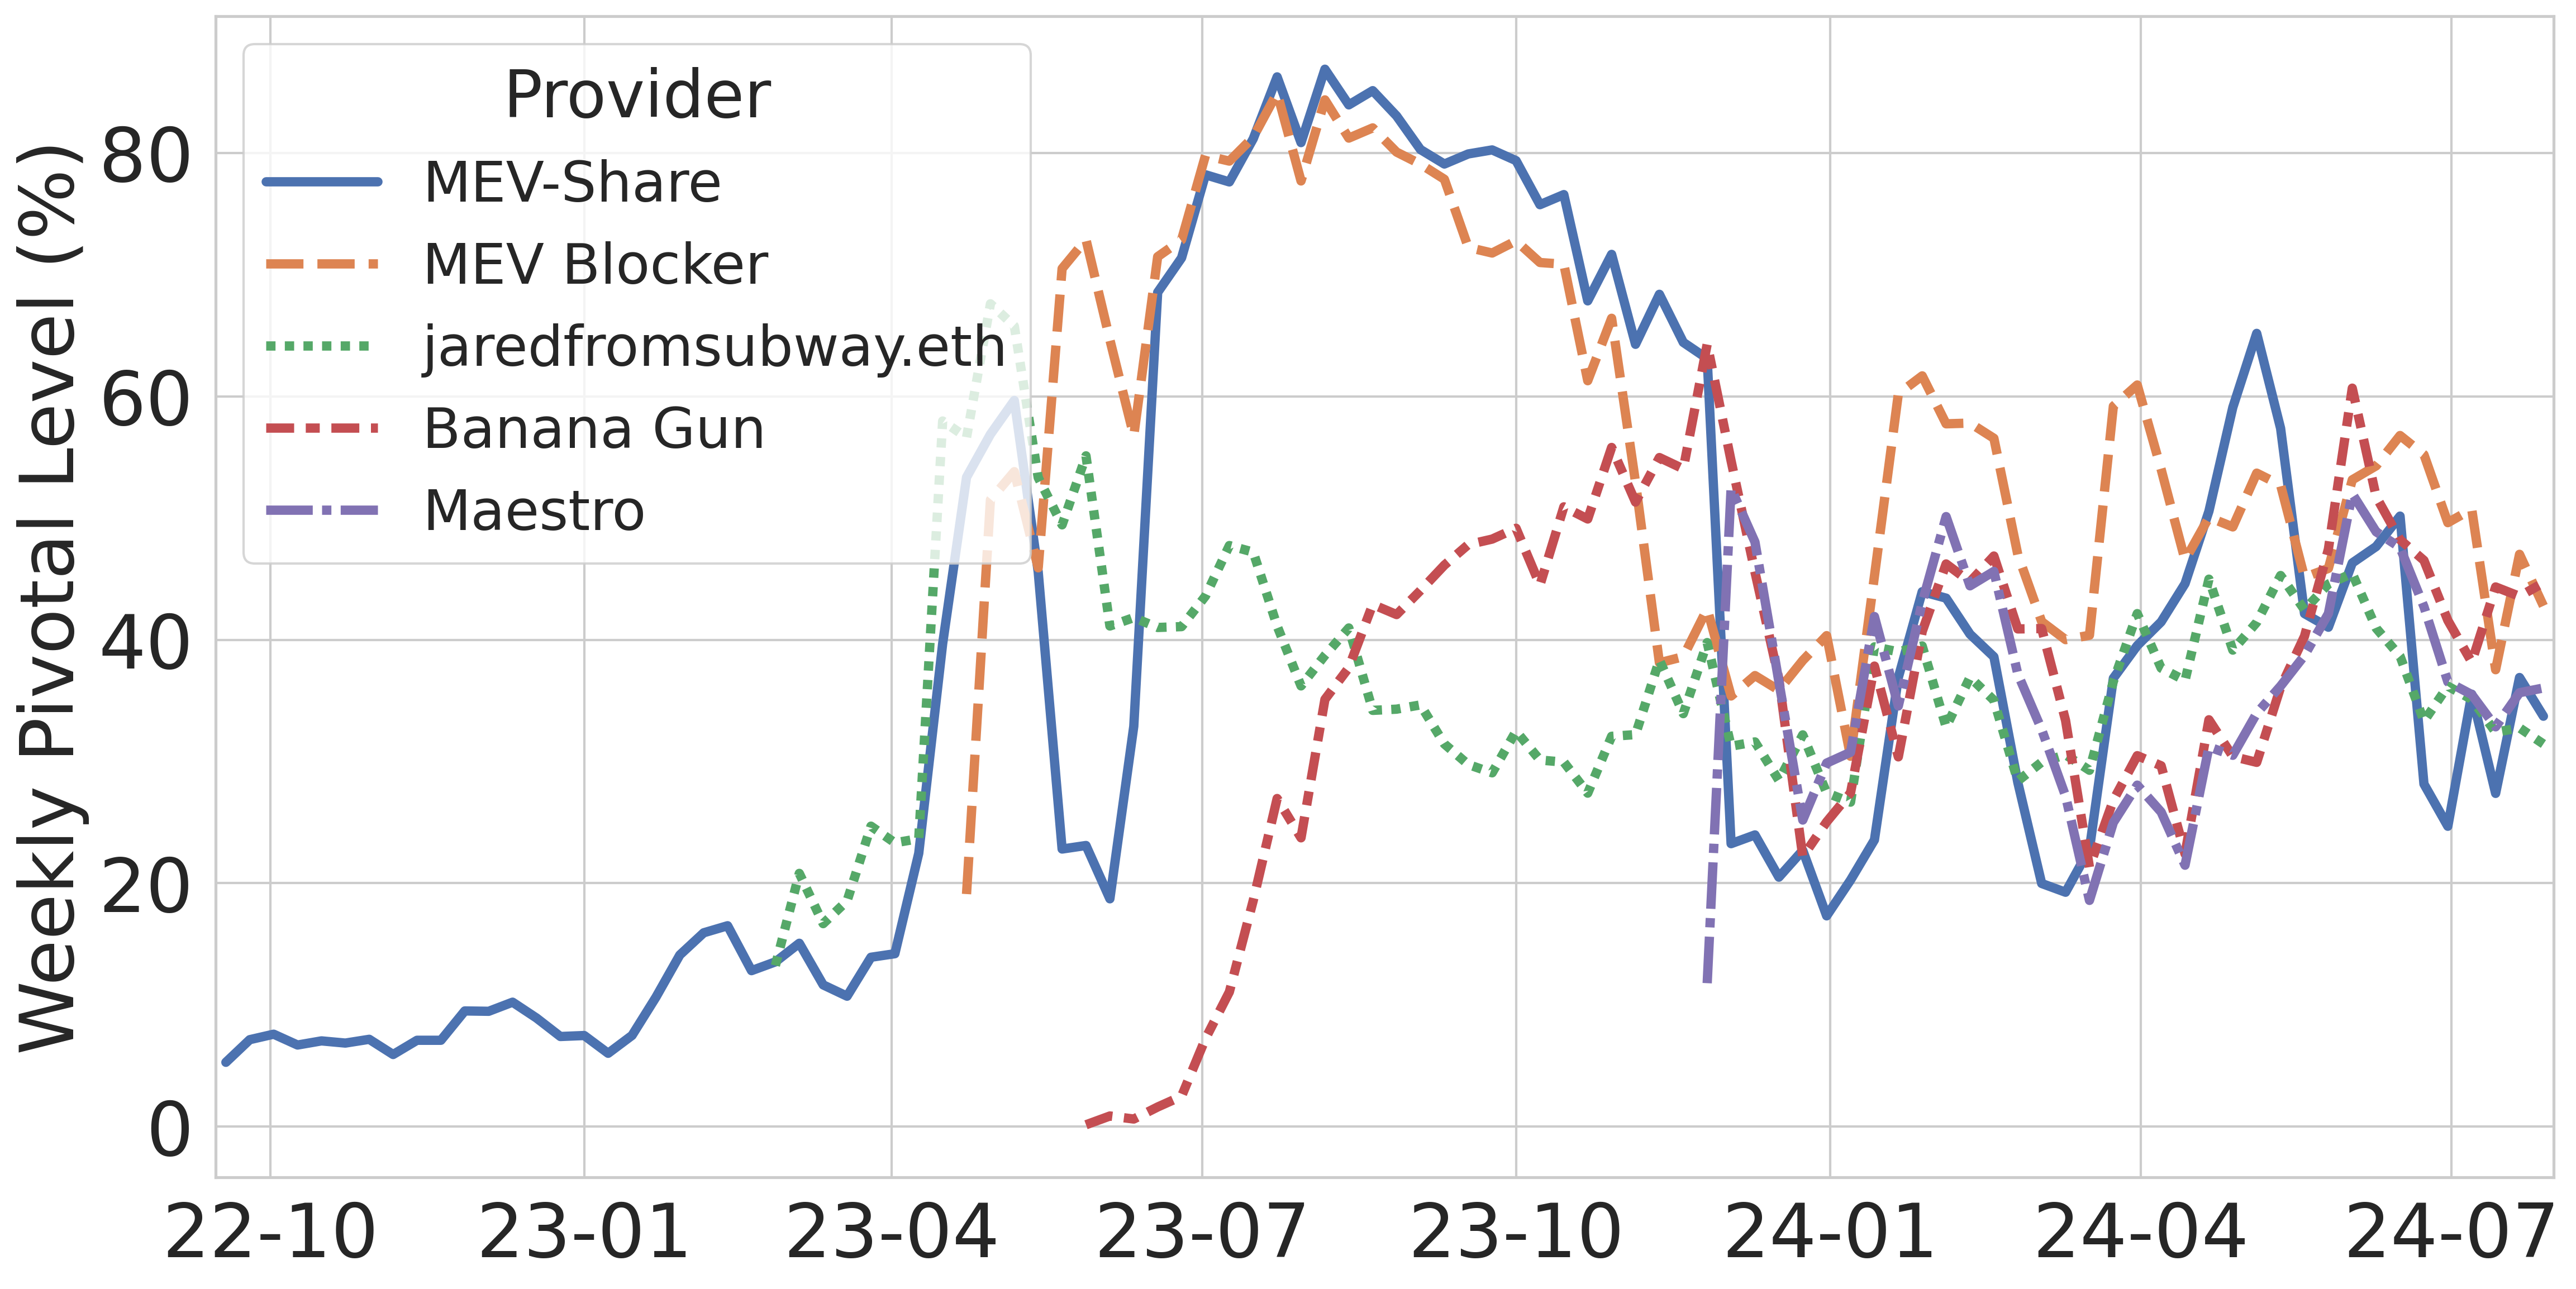

In [39]:
order = [
    'MEV-Share',
    'MEV Blocker',
    'jaredfromsubway.eth',
    "Banana Gun",
    "Maestro",
]

dates = list(pd.date_range("2022-09-15", "2024-07-31", freq="W"))

weekly_provider_data = []
for date in dates:
    week = pd.date_range(date, periods=7)
    week_str = [d.strftime("%Y%m%d") for d in week]
    weekly_blocks_df = blocks_df[blocks_df["date"].isin(week_str)].reindex()
    sub_df = weekly_blocks_df[weekly_blocks_df["builder_pubkey"].notnull()].reindex()
    block_num = sub_df.shape[0]

    weekly_pivotal_providers_df = pivotal_providers_df[pivotal_providers_df["date"].isin(week_str)].reindex()
    counter = Counter(weekly_pivotal_providers_df["provider"])

    for provider, number_of_being_pivotal in counter.items():
        weekly_provider_data.append([date, provider, round(number_of_being_pivotal * 100 / block_num, 2)])


provider_df = pd.DataFrame(weekly_provider_data, columns=["date", "provider", "percentage"])
provider_df = provider_df[provider_df["provider"].isin(order)]
provider_df["provider"] = pd.Categorical(provider_df["provider"], categories=order, ordered=True)
provider_df = provider_df.sort_values("provider")
provider_df["date"] = pd.to_datetime(provider_df["date"])
# remove 0.0% for Maestro
provider_df = provider_df[(provider_df["date"] >= pd.Timestamp("2023-11-26")) | (provider_df["provider"] != "Maestro")].reindex()
sns.set_style("whitegrid")
plt.figure(figsize=(18, 9), dpi=300)
ax = sns.lineplot(data=provider_df, x="date", y="percentage", hue="provider", linewidth=4, style="provider")

handles, labels = ax.get_legend_handles_labels()

for handle in handles:
    handle.set_linewidth(4)
    ax.legend(handles=handles, labels=labels)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylabel("Weekly Pivotal Level (%)", fontsize=32)
plt.xlabel(None)

current_xticks, current_labels = plt.xticks(fontsize=32)
new_labels = []
for text in current_labels:
    if text.get_text()[:2] == "20":
        new_labels.append(text.get_text()[2:])
    else:
        new_labels.append(text.get_text())
plt.xticks(current_xticks, new_labels, fontsize=32)
sns.move_legend(ax, "upper left", fontsize=24, title="Provider", title_fontsize=28)

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')
ax.set_xlim([start_date, end_date])

plt.savefig("images/weekly_pivotal_level.pdf", bbox_inches="tight")
plt.show()

Figure 13: Daily percentage of the value of the transactions originating from Maestro for both MEV-Share and MEV Blocker.

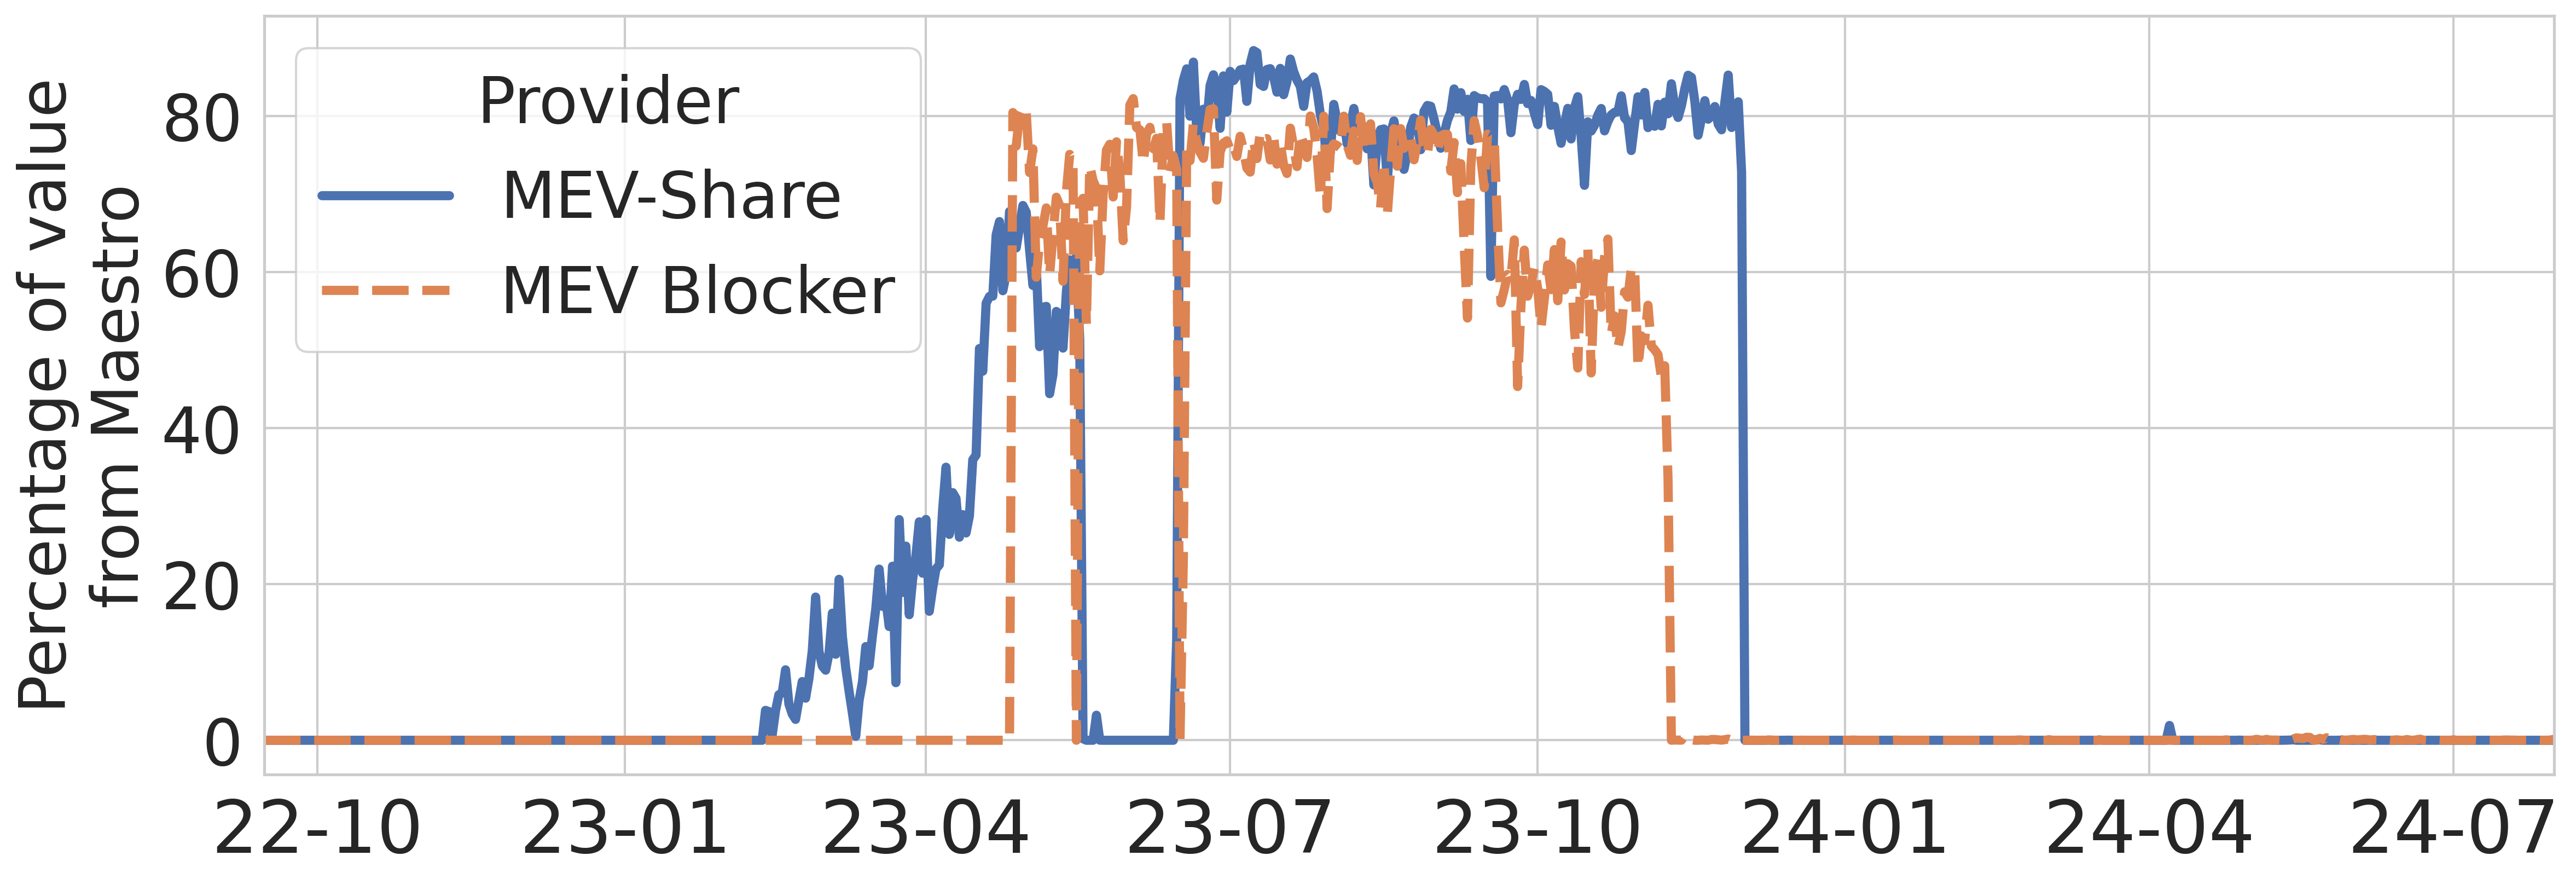

In [37]:
number2date = dict(zip(blocks_df["number"], blocks_df["date"]))
private_txns_df["date"] = private_txns_df["blockNumber"].apply(lambda x: number2date.get(x, None))

maestro_data = []
# for date_str, date_df in blocks_df.groupby("date"):
    # numbers = date_df["number"].unique()
for date_str, sub_df in private_txns_df.groupby("date"):
    mev_share_value = 0 
    mev_blocker_value = 0
    maestro_ms_value = 0
    maestro_mb_value = 0
    for is_mev_share, is_mev_blocker, is_maestro, txn_fee in sub_df[["MEV-Share", "MEV Blocker", "Maestro", "txn_fee"]].values:
        if is_mev_share:
            mev_share_value += txn_fee
            if is_maestro:
                maestro_ms_value += txn_fee
        if is_mev_blocker:
            mev_blocker_value += txn_fee
            if is_maestro:
                maestro_mb_value += txn_fee
    if mev_share_value > 0:
        maestro_data.append((date_str, "MEV-Share", maestro_ms_value*100/mev_share_value))
    else:
        maestro_data.append((date_str, "MEV-Share", 0))
    if mev_blocker_value > 0:
        maestro_data.append((date_str, "MEV Blocker", maestro_mb_value*100/mev_blocker_value))
    else:
        maestro_data.append((date_str, "MEV Blocker", 0))


maestro_data_df = pd.DataFrame(maestro_data, columns=["date", "source", "percentage"])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 6), dpi=300)
maestro_data_df["date"] = pd.to_datetime(maestro_data_df["date"])
ax = sns.lineplot(data=maestro_data_df, x="date", y="percentage", hue="source", linewidth=4, style="source")
handles, labels = ax.get_legend_handles_labels()

for handle in handles:
    handle.set_linewidth(4)
ax.legend(handles=handles, labels=labels)
plt.xticks(fontsize=28)
plt.xlabel(None)
plt.yticks(fontsize=28)
plt.ylabel("Percentage of value\nfrom Maestro", fontsize=28)
sns.move_legend(ax, "upper left", fontsize=28, title_fontsize=28, title="Provider")
current_xticks, current_labels = plt.xticks(fontsize=32)
new_labels = []
for text in current_labels:
    if text.get_text()[:2] == "20":
        new_labels.append(text.get_text()[2:])
    else:
        new_labels.append(text.get_text())
plt.xticks(current_xticks, new_labels, fontsize=32)

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')
ax.set_xlim([start_date, end_date])

plt.savefig("./images/private_revenue_maestro.pdf", bbox_inches="tight")
plt.show()

Figure 14: Weekly builder-specific pivotal level for top-3 builders. MEV-Blocker and MEV-Share are hidden for clarity.

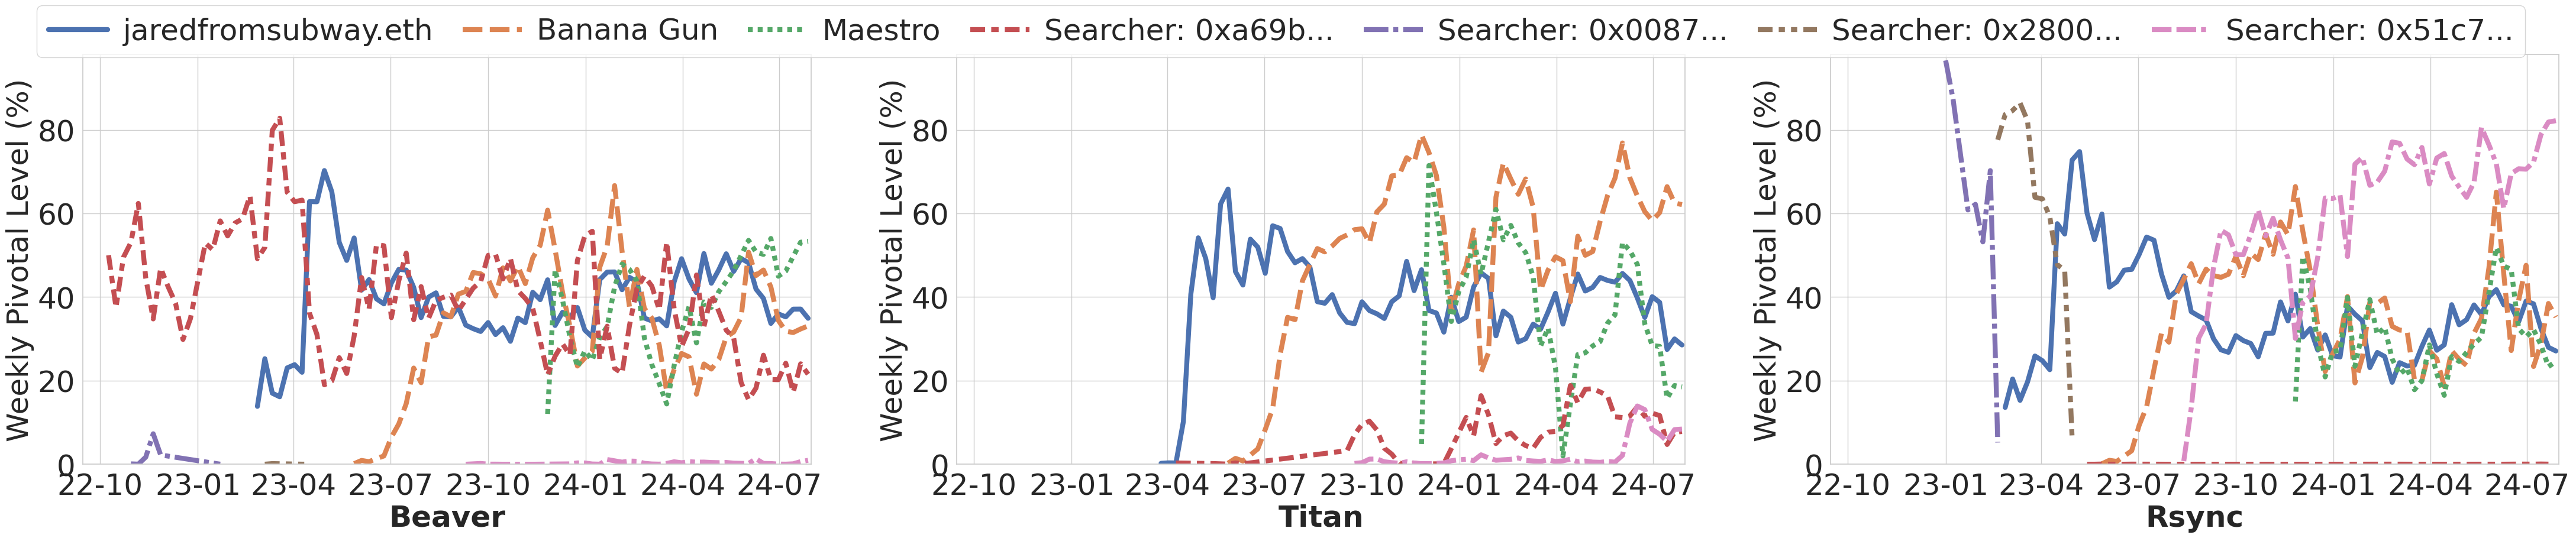

In [46]:
dates = list(pd.date_range("2022-09-15", "2024-07-31", freq="W"))
week_provider_data = defaultdict(list)

for date in dates:
    week = pd.date_range(date, periods=7)
    week_str = [d.strftime("%Y%m%d") for d in week]
    weekly_blocks_df = blocks_df[blocks_df["date"].isin(week_str)].reindex()
    sub_df = weekly_blocks_df[weekly_blocks_df["builder_pubkey"].notnull()].reindex()
    sub_df["builder"] = sub_df["builder_pubkey"].apply(lambda x: builders.get(x, x[:12]))

    weekly_pivotal_providers_df = pivotal_providers_df[pivotal_providers_df["date"].isin(week_str)].reindex()
    builder_to_provider = defaultdict(lambda: defaultdict(int))
    for builder, provider in weekly_pivotal_providers_df[["winner", "provider"]].values:
        builder_to_provider[builder][provider] += 1

    for builder, builder_df in sub_df.groupby("builder"):
        for provider, provider_count in builder_to_provider[builder].items():
            week_provider_data[builder].append([date, provider, 100 * provider_count / builder_df.shape[0]])


rsync_df = pd.DataFrame(week_provider_data["rsync-builder"], columns=["date", "provider", "percentage"])
beaver_df = pd.DataFrame(week_provider_data["beaverbuild"], columns=["date", "provider", "percentage"])
Titan_df = pd.DataFrame(week_provider_data["Titan"], columns=["date", "provider", "percentage"])

total_list = set()
for df in [rsync_df, beaver_df, Titan_df]:
    sub_df=df[df["percentage"] >= 25]
    order = sub_df.groupby("provider").size()
    order_list = order[order >= 4].index.tolist()
    total_list.update(order_list)

# remove MEV-Share and MEV Blocker
total_list -= {"MEV-Share", "MEV Blocker"}

sub_rsync_df = rsync_df[rsync_df["provider"].isin(total_list)].reindex()
sub_beaver_df = beaver_df[beaver_df["provider"].isin(total_list)].reindex()
sub_Titan_df = Titan_df[Titan_df["provider"].isin(total_list)].reindex()

sub_rsync_df["provider"] = sub_rsync_df["provider"].apply(parse_provider)
sub_beaver_df["provider"] = sub_beaver_df["provider"].apply(parse_provider)
sub_Titan_df["provider"] = sub_Titan_df["provider"].apply(parse_provider)
sub_beaver_df["date"] = pd.to_datetime(sub_beaver_df["date"])
sub_rsync_df["date"] = pd.to_datetime(sub_rsync_df["date"])
sub_Titan_df["date"] = pd.to_datetime(sub_Titan_df["date"])

# remove 0.0% for Maestro
sub_Titan_df = sub_Titan_df[(sub_Titan_df["date"] >= pd.Timestamp("2023-11-26")) | (sub_Titan_df["provider"] != "Maestro")].reindex()
sub_beaver_df = sub_beaver_df[(sub_beaver_df["date"] >= pd.Timestamp("2023-11-26")) | (sub_beaver_df["provider"] != "Maestro")].reindex()
sub_rsync_df = sub_rsync_df[(sub_rsync_df["date"] >= pd.Timestamp("2023-11-26")) | (sub_rsync_df["provider"] != "Maestro")].reindex()

hue_ordr = ['jaredfromsubway.eth', 'Banana Gun', 'Maestro', 'Searcher: 0xa69b...', 'Searcher: 0x0087...', 'Searcher: 0x2800...', 'Searcher: 0x51c7...']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18*3, 9))
sns.set_style("whitegrid")
sns.lineplot(data=sub_beaver_df, x="date", y="percentage", hue="provider", linewidth=6, ax=ax1, legend=False, hue_order=hue_ordr, style="provider", style_order=hue_ordr)
sns.lineplot(data=sub_Titan_df, x="date", y="percentage", hue="provider", linewidth=6, ax=ax2, hue_order=hue_ordr, style="provider", style_order=hue_ordr)
sns.lineplot(data=sub_rsync_df, x="date", y="percentage", hue="provider", linewidth=6, ax=ax3, legend=False, hue_order=hue_ordr, style="provider", style_order=hue_ordr)

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')

for ax, xlabel in [(ax1, "Beaver"), (ax2, "Titan"),(ax3, "Rsync")]:
    ax.tick_params(axis='x', labelsize=36)
    ax.tick_params(axis='y', labelsize=36)
    ax.set_ylabel("Weekly Pivotal Level (%)", fontsize=36)
    ax.set_xlabel(xlabel, fontsize=36,fontweight='bold')
    ax.set_ylim([0, 98])
    ax.set_xlim([start_date, end_date])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m')) 

handles, labels = ax2.get_legend_handles_labels()
for handle in handles:
    handle.set_linewidth(6)
ax2.get_legend().remove()
fig.legend(handles, labels, loc='upper center', ncol=7, fontsize=36, handletextpad=0.5, columnspacing=1, bbox_to_anchor=(0.5, 1))

plt.savefig("images/builder-pivotal-level.pdf", bbox_inches="tight")
plt.show()

Figure 15: Weekly builder-specific pivotal levels for the top-3 builders for slots with winning bid values of no less than 0.5 ETH.

In [ ]:
slot_to_bid_value = blocks_df.set_index('slot')['bid_value'].to_dict()
grouped = pivotal_providers_df.groupby('slot').agg({
    'date': 'first',
    'number': 'first',
    'winner': 'first',
    'provider': lambda x: list(x)
}).reset_index()
grouped["bid_value"] = grouped["slot"].apply(lambda x: slot_to_bid_value.get(x, 0))

dates = list(pd.date_range("2022-09-15", "2024-07-31", freq="W"))
week_provider_data = defaultdict(list)
threshold = 0.5

for date in dates:
    week = pd.date_range(date, periods=7)
    week_str = [d.strftime("%Y%m%d") for d in week]
    high_mev_blocks = blocks_df[blocks_df["bid_value"] >= threshold].reindex()

    weekly_blocks_df = high_mev_blocks[high_mev_blocks["date"].isin(week_str)].reindex()
    sub_df = weekly_blocks_df[weekly_blocks_df["builder_pubkey"].notnull()].reindex()
    sub_df["builder"] = sub_df["builder_pubkey"].apply(lambda x: builders.get(x, x[:12]))
    slots = sub_df["slot"].unique()

    weekly_pivotal_providers_df = grouped[grouped["slot"].isin(slots)].reindex()
    builder_to_provider = defaultdict(lambda: defaultdict(int))
    for builder, providers in weekly_pivotal_providers_df[["winner", "provider"]].values:
        if len(providers) > 1:
            continue
        builder_to_provider[builder][providers[0]] += 1

    for builder, builder_df in sub_df.groupby("builder"):
        for provider, provider_count in builder_to_provider[builder].items():
            week_provider_data[builder].append([date, provider, 100 * provider_count / builder_df.shape[0]])

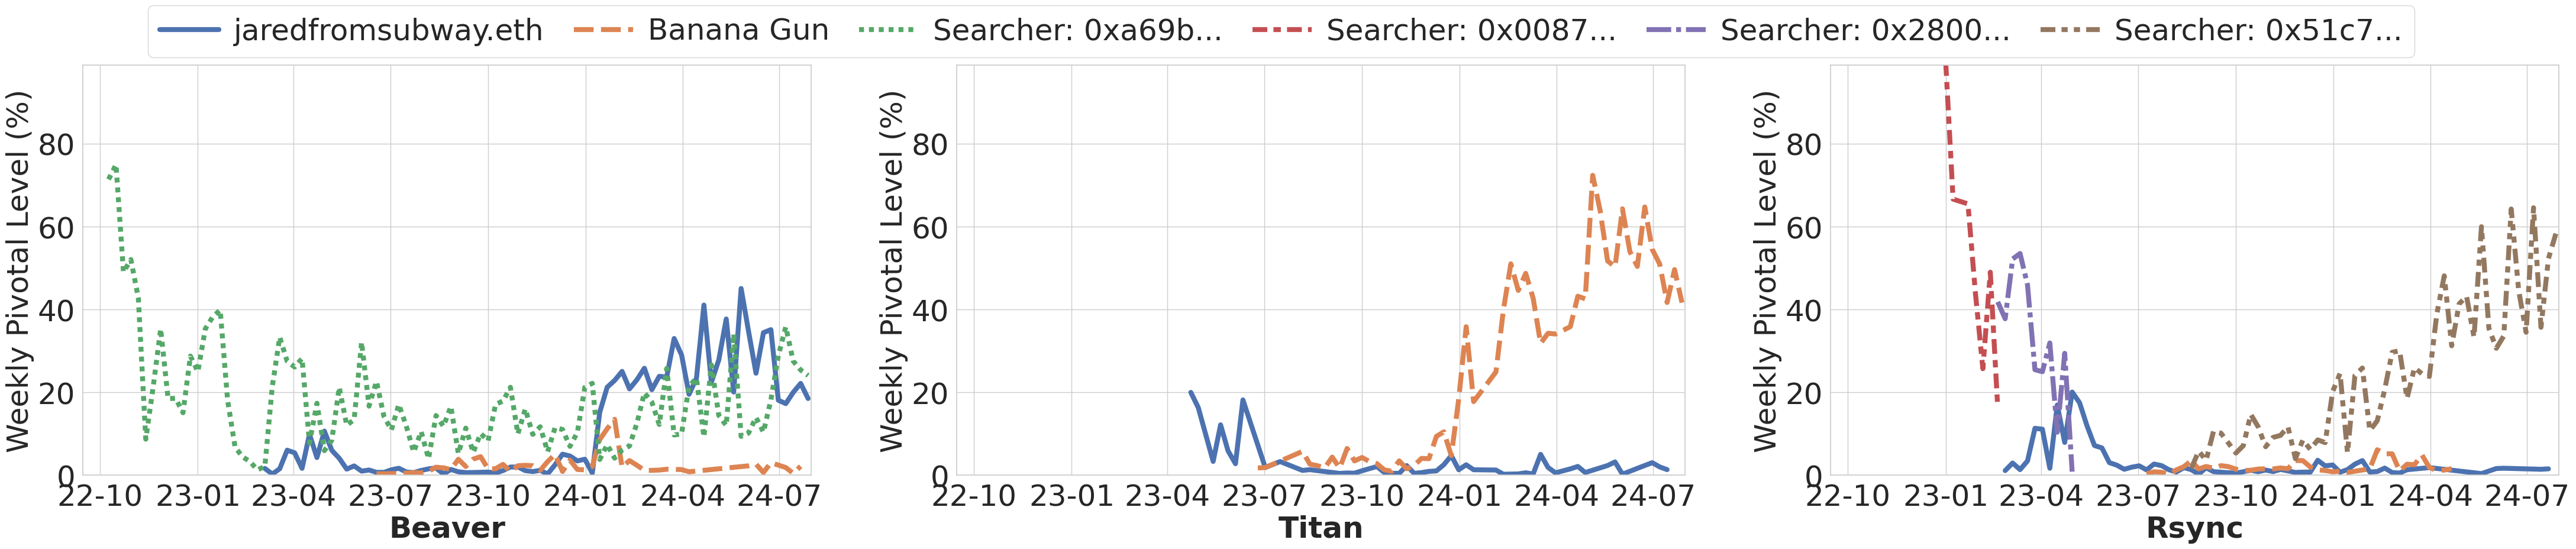

In [59]:
rsync_df = pd.DataFrame(week_provider_data["rsync-builder"], columns=["date", "provider", "percentage"])
beaver_df = pd.DataFrame(week_provider_data["beaverbuild"], columns=["date", "provider", "percentage"])
Titan_df = pd.DataFrame(week_provider_data["Titan"], columns=["date", "provider", "percentage"])

total_list = set()
for df in [rsync_df, beaver_df, Titan_df]:
    sub_df=df[df["percentage"] >= 15]
    order = sub_df.groupby("provider").size()
    order_list = order[order >= 4].index.tolist()
    total_list.update(order_list)

# remove MEV-Share, MEV Blocker, and Maestro
total_list -= {"MEV-Share", "MEV Blocker", "Maestro"}

sub_rsync_df = rsync_df[rsync_df["provider"].isin(total_list)].reindex()
sub_beaver_df = beaver_df[beaver_df["provider"].isin(total_list)].reindex()
sub_Titan_df = Titan_df[Titan_df["provider"].isin(total_list)].reindex()

sub_rsync_df["provider"] = sub_rsync_df["provider"].apply(parse_provider)
sub_beaver_df["provider"] = sub_beaver_df["provider"].apply(parse_provider)
sub_Titan_df["provider"] = sub_Titan_df["provider"].apply(parse_provider)
sub_beaver_df["date"] = pd.to_datetime(sub_beaver_df["date"])
sub_rsync_df["date"] = pd.to_datetime(sub_rsync_df["date"])
sub_Titan_df["date"] = pd.to_datetime(sub_Titan_df["date"])

# remove 0.0% for Maestro
sub_Titan_df = sub_Titan_df[(sub_Titan_df["date"] >= pd.Timestamp("2023-11-26")) | (sub_Titan_df["provider"] != "Maestro")].reindex()
sub_beaver_df = sub_beaver_df[(sub_beaver_df["date"] >= pd.Timestamp("2023-11-26")) | (sub_beaver_df["provider"] != "Maestro")].reindex()
sub_rsync_df = sub_rsync_df[(sub_rsync_df["date"] >= pd.Timestamp("2023-11-26")) | (sub_rsync_df["provider"] != "Maestro")].reindex()

hue_ordr = ['jaredfromsubway.eth', 'Banana Gun', 'Searcher: 0xa69b...', 'Searcher: 0x0087...', 'Searcher: 0x2800...', 'Searcher: 0x51c7...']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18*3, 9))
sns.set_style("whitegrid")
sns.lineplot(data=sub_beaver_df, x="date", y="percentage", hue="provider", linewidth=6, ax=ax1, legend=False, hue_order=hue_ordr, style="provider", style_order=hue_ordr)
sns.lineplot(data=sub_Titan_df, x="date", y="percentage", hue="provider", linewidth=6, ax=ax2, hue_order=hue_ordr, style="provider", style_order=hue_ordr)
sns.lineplot(data=sub_rsync_df, x="date", y="percentage", hue="provider", linewidth=6, ax=ax3, legend=False, hue_order=hue_ordr, style="provider", style_order=hue_ordr)

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')

for ax, xlabel in [(ax1, "Beaver"), (ax2, "Titan"),(ax3, "Rsync")]:
    ax.tick_params(axis='x', labelsize=36)
    ax.tick_params(axis='y', labelsize=36)
    ax.set_ylabel("Weekly Pivotal Level (%)", fontsize=36)
    ax.set_xlabel(xlabel, fontsize=36,fontweight='bold')
    ax.set_ylim([0, 99])
    ax.set_xlim([start_date, end_date])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m')) 

handles, labels = ax2.get_legend_handles_labels()
for handle in handles:
    handle.set_linewidth(6)
ax2.get_legend().remove()
fig.legend(handles, labels, loc='upper center', ncol=7, fontsize=36, handletextpad=0.5, columnspacing=1, bbox_to_anchor=(0.5, 1.02))

plt.savefig("images/single-builder-pivotal-level.pdf", bbox_inches="tight")
plt.show()

## Computing Market Share Cost

Figure 16: Subsidy required to establish a 1% market share, as required by MEV Blocker.

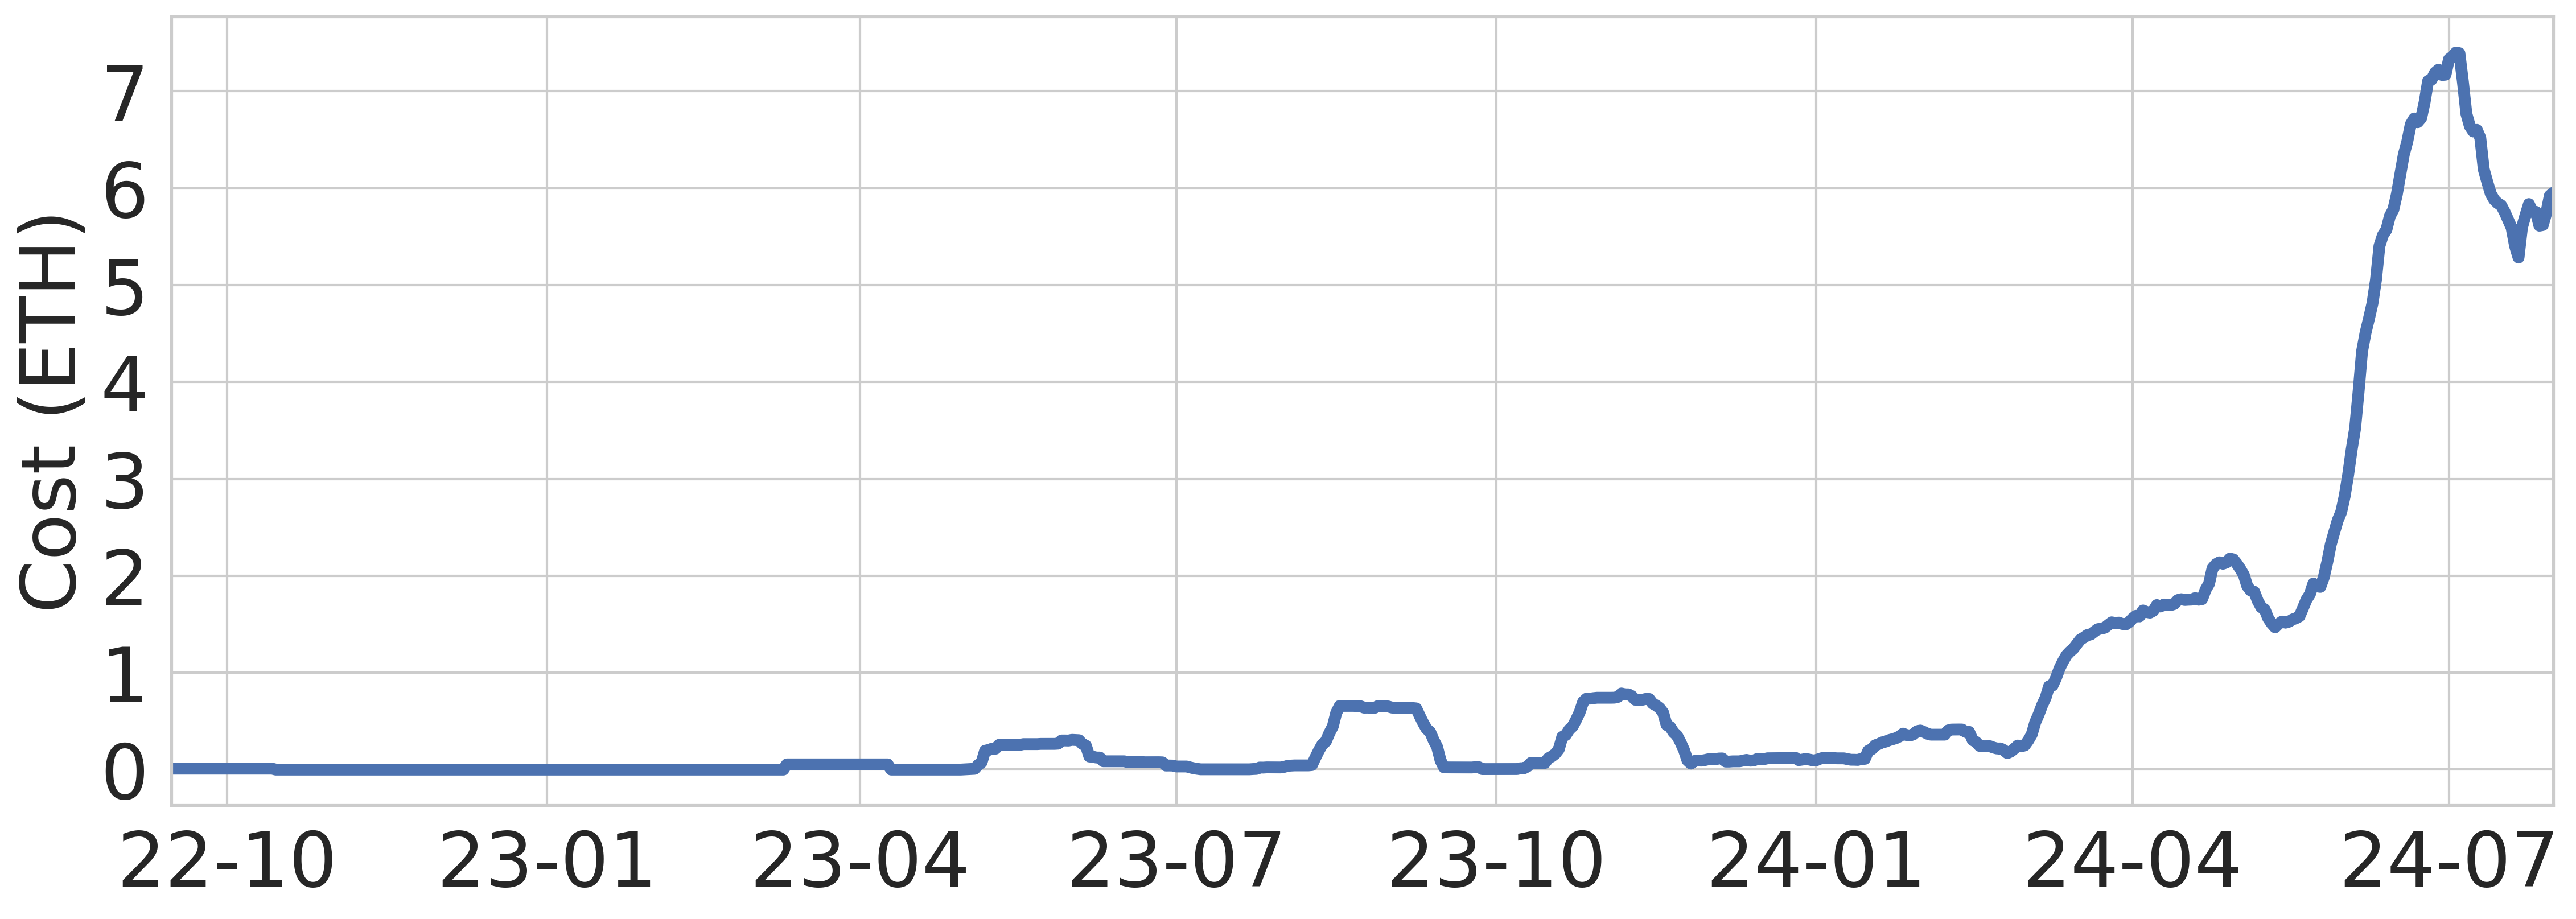

In [11]:
def calc_subsidy(item):
    public_value = item["block_value"] - item["private_order_flow_value"]
    return max(item["bid_value"], item["block_value"]) - public_value


data_df["subsidy"] = data_df.apply(calc_subsidy, axis=1)
data_df['date'] = pd.to_datetime(data_df['date'])
daily_private_profit = []
for date, sub_date_df in data_df.groupby("date"):
    daily_private_profit.append((date, sub_date_df["subsidy"].nsmallest(72).sum()))

daily_private_profit_df = pd.DataFrame(daily_private_profit, columns=["date", "subsidy"])
window_size = 30
extended_subsidy = pd.Series(daily_private_profit_df['subsidy'].tolist() + [daily_private_profit_df['subsidy'].iloc[-1]] * (window_size - 1))
rolling_sum = extended_subsidy.rolling(window=window_size, min_periods=1).sum()

daily_private_profit_df['subsidy_sum_next_30'] = rolling_sum.iloc[:len(daily_private_profit_df)].reset_index(drop=True)
daily_private_profit_df["cost"] = daily_private_profit_df['subsidy_sum_next_30']/1e18


plt.figure(figsize=(18, 6), dpi=300)
sns.set_style("whitegrid")
ax = sns.lineplot(data=daily_private_profit_df, x="date", y="cost", linewidth=5)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel(None)

plt.ylabel("Cost (ETH)", fontsize=32)

current_xticks, current_labels = plt.xticks(fontsize=32)
new_labels = []
for text in current_labels:
    if text.get_text()[:2] == "20":
        new_labels.append(text.get_text()[2:])
    else:
        new_labels.append(text.get_text())

start_date = pd.Timestamp('2022-09-15')
end_date = pd.Timestamp('2024-07-31')
ax.set_xlim([start_date, end_date])

plt.xticks(current_xticks, new_labels, fontsize=32)
plt.savefig("images/market_share_cost.pdf", bbox_inches='tight')
plt.show()